In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sqlalchemy as db

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim import Adam

In [2]:
print("CUDA available", torch.cuda.is_available())
print("CUDA dev count", torch.cuda.device_count())
print("CUDA dev curr", torch.cuda.current_device())
print("CUDA dev", torch.cuda.device(0))
print("CUDA dev name", torch.cuda.get_device_name(0))

CUDA available True
CUDA dev count 1
CUDA dev curr 0
CUDA dev <torch.cuda.device object at 0x0000025592E2FED0>
CUDA dev name NVIDIA GeForce GTX 1650


Connection to DLSU Cloud DB (PAL)
- `connection.json` is abstracted for data privacy

In [7]:
conn = pd.read_json('connection.json', typ='series')
host = conn['host']
user = conn['user']
password = conn['password']
port = conn['port']

db_name = input('DB Name: ')
engine = db.create_engine('mysql+pymysql://' + user + ':' + password + '@' + host + ':' + port + '/' + db_name)

DB Name: Historical


Reading the Historical Data

In [8]:
query = "SELECT * FROM PALB777_hour"
hist = pd.read_sql(query, engine)

# EDA & Preprocessing

In [9]:
hist.index = hist['index']
hist.drop('index', axis=1, inplace=True)

In [10]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15167 entries, 2022-01-01 00:00:00 to 2023-09-24 22:00:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rp7772  15167 non-null  float64
 1   rp7773  15167 non-null  float64
 2   rp7774  15167 non-null  float64
 3   rp7775  15167 non-null  float64
 4   rp7776  15167 non-null  float64
 5   rp7777  15167 non-null  float64
 6   rp7778  15167 non-null  float64
 7   rp7779  15167 non-null  float64
 8   rp7782  15167 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [11]:
hist.describe()

,rp7772,rp7773,rp7774,rp7775,rp7776,rp7777,rp7778,rp7779,rp7782
count,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000,15167.000000
mean,9084.342686,5085.247437,569.734959,3459.848711,3675.624093,4694.237881,5817.094252,5701.875285,6154.639672
std,10095.576421,8944.019925,3508.308840,7782.193918,7986.441379,8816.908037,9064.834853,9137.011880,9668.689192
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1762.191111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17731.146667,11142.077778,0.000000,0.000000,0.000000,761.437778,15609.200000,15453.533333,15790.866667
max,47314.755556,45496.164444,44033.791111,59026.795556,51505.040000,52611.413333,43916.324444,52218.631111,82163.244444


Data Aggregation

In [12]:
agg = input("Monthly [M], Weekly [W], Daily [D], Hourly [H]: ")
agg = agg.upper()
if agg == 'W':
    agg += '-' + hist.index[1].day_name()[:3]
placeholder = hist
hist = hist.resample(agg).sum()
hist

Monthly [M], Weekly [W], Daily [D], Hourly [H]: h


,rp7772,rp7773,rp7774,rp7775,rp7776,rp7777,rp7778,rp7779,rp7782
index,,,,,,,,,
2022-01-01 00:00:00,14937.640000,0.0,0.0,0.0,13186.493333,0.0,0.0,0.0,0.0
2022-01-01 01:00:00,7586.662222,0.0,0.0,0.0,9737.026667,0.0,0.0,0.0,0.0
2022-01-01 02:00:00,61.453333,0.0,0.0,0.0,1589.364444,0.0,0.0,0.0,0.0
2022-01-01 03:00:00,17754.422222,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2022-01-01 04:00:00,15098.808889,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2023-09-24 18:00:00,16529.582222,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2023-09-24 19:00:00,16379.431111,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2023-09-24 20:00:00,15552.746667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Separate the data

In [9]:
rp72 = hist[['rp7772']].rename({'rp7772':'ff'}, axis=1)
rp73 = hist[['rp7773']].rename({'rp7773':'ff'}, axis=1)
rp74 = hist[['rp7774']].rename({'rp7774':'ff'}, axis=1)
rp75 = hist[['rp7775']].rename({'rp7775':'ff'}, axis=1)
rp76 = hist[['rp7776']].rename({'rp7776':'ff'}, axis=1)
rp77 = hist[['rp7777']].rename({'rp7777':'ff'}, axis=1)
rp78 = hist[['rp7778']].rename({'rp7778':'ff'}, axis=1)
rp79 = hist[['rp7779']].rename({'rp7779':'ff'}, axis=1)
rp782 = hist[['rp7782']].rename({'rp7782':'ff'}, axis=1)

Process the main data (rp7772)

In [10]:
ss = StandardScaler()
ss.fit(rp72) # main data for standardization
time_step = 408 # time step for preprocessing
pred_step = 1 # number of predictions

def time_step_prep(data, time_step,pred_step):
    X = []
    y = []
    for i in range(time_step, data.shape[0]-pred_step):
        X.append(list(data.iloc[i-time_step:i, 0].values.reshape(-1)))
        y.append(list(data.iloc[i:i+pred_step, 0].values.reshape(-1)))
    return X, y

In [ ]:
n_rp72 = pd.DataFrame(ss.transform(rp72))
X, y = time_step_prep(n_rp72, time_step, pred_step)
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), train_size=0.5, shuffle=False)

Add more data to training set

In [657]:
n_rp = [rp73,rp74,rp75,rp76,rp77,rp78,rp79,rp782]

In [658]:
for each in n_rp:
    n_each = pd.DataFrame(ss.transform(each))
    n_X, n_y = time_step_prep(n_each, time_step, pred_step)
    X_train = np.concatenate([X_train, np.array(n_X)])
    y_train = np.concatenate([y_train, np.array(n_y)])

Convert the data to torch

In [659]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

# Prediction Models

Construct Prediction Models

In [660]:
# LSTM based prediction model
class LSTM_based(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.lstm = nn.LSTM(self.in_dim, self.hid_dim, self.layer, batch_first=True)
        
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):        
        # forward propagate
        out, (h_,c_) = self.lstm(x)
        out = self.fc(out)
        return out
    
# RNN based prediction model
class RNN_based(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        
        # define the dimensions
        self.in_dim = in_dim
        self.hid_dim = in_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        # define the rnn layer
        self.rnn = nn.RNN(self.in_dim, self.hid_dim, self.layer, nonlinearity='relu', batch_first=True)
        
        # define fully connected layer for output
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        # forward propagate
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

# Simple Autoregressive Model
auto_reg = nn.Linear(time_step,pred_step)

In [661]:
input_features = X_train.shape[-1]
hidden_size = 32
num_layers = 2
out_size = 1

# model = LSTM_based(input_features, hidden_size, out_size, num_layers)
model = auto_reg

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fun = nn.MSELoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)

In [662]:
def train_model(model,
               criterion,
               optimizer,
               x_train,
               x_test,
               y_train,
               y_test,
               scheduler=None,
               epochs=500):
    
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        # put default model grads to zero
        optimizer.zero_grad()
        
        # predict the output
        pred = model(x_train)
        
        # calculate the loss 
        error = criterion(pred, y_train)
        
        # backpropagate the error
        error.backward()
        
        # update the model parameters
        optimizer.step()
        
        # save the losses 
        train_loss[epoch] = error.item()
        
        # test loss 
        test_pred = model(x_test)
        test_error = criterion(y_test,test_pred)
        test_loss[epoch] = test_error.item()
        
        # scheduler
        if scheduler is not None:
            scheduler.step()
        
        if (epoch+1) % 5 ==0:
            print('Epoch :{}    Train Loss :{}    Test Loss :{}'.format((epoch+1)/epochs, error.item(), test_error.item()))
            
    return train_loss, test_loss

In [346]:
train_loss, test_loss = train_model(
    model, 
    loss_fun,
    optimizer, 
    X_train, 
    X_test,
    y_train, 
    y_test,
    scheduler,
    20000
)

Epoch :0.00025    Train Loss :3.3522303104400635    Test Loss :1.235198736190796
Epoch :0.0005    Train Loss :1.8256306648254395    Test Loss :0.9569211006164551
Epoch :0.00075    Train Loss :1.1384804248809814    Test Loss :0.6528809070587158
Epoch :0.001    Train Loss :0.7407453060150146    Test Loss :0.6421806216239929
Epoch :0.00125    Train Loss :0.5018235445022583    Test Loss :0.49877768754959106
Epoch :0.0015    Train Loss :0.36554282903671265    Test Loss :0.4800935685634613
Epoch :0.00175    Train Loss :0.2892893850803375    Test Loss :0.40151041746139526
Epoch :0.002    Train Loss :0.24447305500507355    Test Loss :0.39744436740875244
Epoch :0.00225    Train Loss :0.2136029452085495    Test Loss :0.3558562695980072
Epoch :0.0025    Train Loss :0.18998266756534576    Test Loss :0.35286444425582886
Epoch :0.00275    Train Loss :0.17249919474124908    Test Loss :0.3390102982521057
Epoch :0.003    Train Loss :0.16236838698387146    Test Loss :0.33479252457618713
Epoch :0.00325  

Epoch :0.02725    Train Loss :0.1543624997138977    Test Loss :0.3209538459777832
Epoch :0.0275    Train Loss :0.1543624997138977    Test Loss :0.3209538757801056
Epoch :0.02775    Train Loss :0.1543624997138977    Test Loss :0.3209538459777832
Epoch :0.028    Train Loss :0.1543624997138977    Test Loss :0.3209538459777832
Epoch :0.02825    Train Loss :0.1543625146150589    Test Loss :0.3209538459777832
Epoch :0.0285    Train Loss :0.1543624997138977    Test Loss :0.3209538757801056
Epoch :0.02875    Train Loss :0.1543624848127365    Test Loss :0.3209538459777832
Epoch :0.029    Train Loss :0.1543625146150589    Test Loss :0.3209538757801056
Epoch :0.02925    Train Loss :0.1543625146150589    Test Loss :0.3209537863731384
Epoch :0.0295    Train Loss :0.1543625146150589    Test Loss :0.3209538459777832
Epoch :0.02975    Train Loss :0.1543624997138977    Test Loss :0.3209537863731384
Epoch :0.03    Train Loss :0.1543624997138977    Test Loss :0.3209540843963623
Epoch :0.03025    Train Lo

Epoch :0.05325    Train Loss :0.1543625146150589    Test Loss :0.32095402479171753
Epoch :0.0535    Train Loss :0.1543625146150589    Test Loss :0.3209538757801056
Epoch :0.05375    Train Loss :0.1543624997138977    Test Loss :0.32095393538475037
Epoch :0.054    Train Loss :0.1543624997138977    Test Loss :0.3209540545940399
Epoch :0.05425    Train Loss :0.1543625146150589    Test Loss :0.32095396518707275
Epoch :0.0545    Train Loss :0.1543624997138977    Test Loss :0.32095393538475037
Epoch :0.05475    Train Loss :0.1543624997138977    Test Loss :0.32095402479171753
Epoch :0.055    Train Loss :0.1543625146150589    Test Loss :0.32095393538475037
Epoch :0.05525    Train Loss :0.1543624997138977    Test Loss :0.3209538757801056
Epoch :0.0555    Train Loss :0.1543624848127365    Test Loss :0.3209540843963623
Epoch :0.05575    Train Loss :0.1543625146150589    Test Loss :0.32095396518707275
Epoch :0.056    Train Loss :0.1543624997138977    Test Loss :0.32095393538475037
Epoch :0.05625   

Epoch :0.08025    Train Loss :0.15441907942295074    Test Loss :0.3214687407016754
Epoch :0.0805    Train Loss :0.15505972504615784    Test Loss :0.31982019543647766
Epoch :0.08075    Train Loss :0.16462986171245575    Test Loss :0.3358674943447113
Epoch :0.081    Train Loss :0.2864954471588135    Test Loss :0.386543333530426
Epoch :0.08125    Train Loss :0.1809169352054596    Test Loss :0.31982535123825073
Epoch :0.0815    Train Loss :0.1998693197965622    Test Loss :0.3258765637874603
Epoch :0.08175    Train Loss :0.1866980940103531    Test Loss :0.3263707756996155
Epoch :0.082    Train Loss :0.17360804975032806    Test Loss :0.3246690332889557
Epoch :0.08225    Train Loss :0.16517062485218048    Test Loss :0.3231959939002991
Epoch :0.0825    Train Loss :0.1603475660085678    Test Loss :0.3222895562648773
Epoch :0.08275    Train Loss :0.1577494740486145    Test Loss :0.32182273268699646
Epoch :0.083    Train Loss :0.15637288987636566    Test Loss :0.321615606546402
Epoch :0.08325    

Epoch :0.10525    Train Loss :0.1543625146150589    Test Loss :0.3209518790245056
Epoch :0.1055    Train Loss :0.1543624848127365    Test Loss :0.32095617055892944
Epoch :0.10575    Train Loss :0.1543625146150589    Test Loss :0.32095205783843994
Epoch :0.106    Train Loss :0.1543625146150589    Test Loss :0.3209572434425354
Epoch :0.10625    Train Loss :0.1543625146150589    Test Loss :0.32094889879226685
Epoch :0.1065    Train Loss :0.1543625146150589    Test Loss :0.3209611773490906
Epoch :0.10675    Train Loss :0.15436257421970367    Test Loss :0.32093918323516846
Epoch :0.107    Train Loss :0.15436293184757233    Test Loss :0.3209933340549469
Epoch :0.10725    Train Loss :0.15436631441116333    Test Loss :0.3208352327346802
Epoch :0.1075    Train Loss :0.15440547466278076    Test Loss :0.32140305638313293
Epoch :0.10775    Train Loss :0.1549496054649353    Test Loss :0.3198651075363159
Epoch :0.108    Train Loss :0.16384439170360565    Test Loss :0.33515262603759766
Epoch :0.10825

Epoch :0.13075    Train Loss :0.1543624997138977    Test Loss :0.320957213640213
Epoch :0.131    Train Loss :0.1543624997138977    Test Loss :0.3209550082683563
Epoch :0.13125    Train Loss :0.1543625146150589    Test Loss :0.32095053791999817
Epoch :0.1315    Train Loss :0.1543625146150589    Test Loss :0.32095903158187866
Epoch :0.13175    Train Loss :0.1543625146150589    Test Loss :0.32094699144363403
Epoch :0.132    Train Loss :0.1543625295162201    Test Loss :0.3209644556045532
Epoch :0.13225    Train Loss :0.15436257421970367    Test Loss :0.3209385573863983
Epoch :0.1325    Train Loss :0.15436266362667084    Test Loss :0.3209766149520874
Epoch :0.13275    Train Loss :0.15436303615570068    Test Loss :0.32091405987739563
Epoch :0.133    Train Loss :0.15436455607414246    Test Loss :0.3210372030735016
Epoch :0.13325    Train Loss :0.15437297523021698    Test Loss :0.32077035307884216
Epoch :0.1335    Train Loss :0.15443161129951477    Test Loss :0.3215026557445526
Epoch :0.13375 

Epoch :0.15675    Train Loss :0.1543632596731186    Test Loss :0.32090315222740173
Epoch :0.157    Train Loss :0.1543673723936081    Test Loss :0.3210892677307129
Epoch :0.15725    Train Loss :0.15439897775650024    Test Loss :0.32061222195625305
Epoch :0.1575    Train Loss :0.15469564497470856    Test Loss :0.3223344385623932
Epoch :0.15775    Train Loss :0.15798629820346832    Test Loss :0.31995558738708496
Epoch :0.158    Train Loss :0.19710177183151245    Test Loss :0.36567872762680054
Epoch :0.15825    Train Loss :0.3543965518474579    Test Loss :0.37819844484329224
Epoch :0.1585    Train Loss :0.18682867288589478    Test Loss :0.34258294105529785
Epoch :0.15875    Train Loss :0.1546846330165863    Test Loss :0.32298192381858826
Epoch :0.159    Train Loss :0.15702147781848907    Test Loss :0.31966888904571533
Epoch :0.15925    Train Loss :0.16019736230373383    Test Loss :0.32080793380737305
Epoch :0.1595    Train Loss :0.16093260049819946    Test Loss :0.3224469721317291
Epoch :0

Epoch :0.183    Train Loss :0.15520143508911133    Test Loss :0.3197546601295471
Epoch :0.18325    Train Loss :0.1702740341424942    Test Loss :0.34277454018592834
Epoch :0.1835    Train Loss :0.37899792194366455    Test Loss :0.43244731426239014
Epoch :0.18375    Train Loss :0.15444611012935638    Test Loss :0.3323489725589752
Epoch :0.184    Train Loss :0.1580275297164917    Test Loss :0.32307782769203186
Epoch :0.18425    Train Loss :0.15472446382045746    Test Loss :0.322777658700943
Epoch :0.1845    Train Loss :0.15526185929775238    Test Loss :0.32299715280532837
Epoch :0.18475    Train Loss :0.15837611258029938    Test Loss :0.32233431935310364
Epoch :0.185    Train Loss :0.16036754846572876    Test Loss :0.3211152255535126
Epoch :0.18525    Train Loss :0.16018050909042358    Test Loss :0.3201119601726532
Epoch :0.1855    Train Loss :0.15873506665229797    Test Loss :0.31968995928764343
Epoch :0.18575    Train Loss :0.1571475714445114    Test Loss :0.3197489082813263
Epoch :0.18

Epoch :0.2095    Train Loss :0.1543625146150589    Test Loss :0.32095035910606384
Epoch :0.20975    Train Loss :0.1543625146150589    Test Loss :0.3209586441516876
Epoch :0.21    Train Loss :0.1543625146150589    Test Loss :0.32094788551330566
Epoch :0.21025    Train Loss :0.1543625444173813    Test Loss :0.320963054895401
Epoch :0.2105    Train Loss :0.15436257421970367    Test Loss :0.320937842130661
Epoch :0.21075    Train Loss :0.15436284244060516    Test Loss :0.3209882974624634
Epoch :0.211    Train Loss :0.1543644517660141    Test Loss :0.32087209820747375
Epoch :0.21125    Train Loss :0.15437689423561096    Test Loss :0.32119542360305786
Epoch :0.2115    Train Loss :0.1544930338859558    Test Loss :0.32034292817115784
Epoch :0.21175    Train Loss :0.15578873455524445    Test Loss :0.3244401216506958
Epoch :0.212    Train Loss :0.17236445844173431    Test Loss :0.32648199796676636
Epoch :0.21225    Train Loss :0.3216216266155243    Test Loss :0.4409010112285614
Epoch :0.2125    

Epoch :0.2355    Train Loss :0.1543625146150589    Test Loss :0.3209504783153534
Epoch :0.23575    Train Loss :0.1543625146150589    Test Loss :0.3209591805934906
Epoch :0.236    Train Loss :0.1543624997138977    Test Loss :0.32094821333885193
Epoch :0.23625    Train Loss :0.1543625146150589    Test Loss :0.32095783948898315
Epoch :0.2365    Train Loss :0.1543624997138977    Test Loss :0.32094916701316833
Epoch :0.23675    Train Loss :0.1543625146150589    Test Loss :0.32096031308174133
Epoch :0.237    Train Loss :0.1543625295162201    Test Loss :0.3209444284439087
Epoch :0.23725    Train Loss :0.15436258912086487    Test Loss :0.32097160816192627
Epoch :0.2375    Train Loss :0.1543629765510559    Test Loss :0.32091376185417175
Epoch :0.23775    Train Loss :0.154365673661232    Test Loss :0.3210628926753998
Epoch :0.238    Train Loss :0.154387429356575    Test Loss :0.3206666111946106
Epoch :0.23825    Train Loss :0.1545998603105545    Test Loss :0.3220933675765991
Epoch :0.2385    Tra

Epoch :0.262    Train Loss :0.1543624997138977    Test Loss :0.3209574222564697
Epoch :0.26225    Train Loss :0.1543625146150589    Test Loss :0.3209483027458191
Epoch :0.2625    Train Loss :0.1543625444173813    Test Loss :0.3209679424762726
Epoch :0.26275    Train Loss :0.15436288714408875    Test Loss :0.3209175765514374
Epoch :0.263    Train Loss :0.15436531603336334    Test Loss :0.32105764746665955
Epoch :0.26325    Train Loss :0.15438693761825562    Test Loss :0.32066652178764343
Epoch :0.2635    Train Loss :0.1546199917793274    Test Loss :0.3221617639064789
Epoch :0.26375    Train Loss :0.15759055316448212    Test Loss :0.31988435983657837
Epoch :0.264    Train Loss :0.19822493195533752    Test Loss :0.3677353262901306
Epoch :0.26425    Train Loss :0.3881809711456299    Test Loss :0.3896641731262207
Epoch :0.2645    Train Loss :0.20233537256717682    Test Loss :0.35091352462768555
Epoch :0.26475    Train Loss :0.15998420119285583    Test Loss :0.32873988151550293
Epoch :0.265 

Epoch :0.289    Train Loss :0.1543624997138977    Test Loss :0.32095539569854736
Epoch :0.28925    Train Loss :0.1543625146150589    Test Loss :0.32095202803611755
Epoch :0.2895    Train Loss :0.1543624997138977    Test Loss :0.32095423340797424
Epoch :0.28975    Train Loss :0.1543624848127365    Test Loss :0.3209547698497772
Epoch :0.29    Train Loss :0.1543625146150589    Test Loss :0.32095369696617126
Epoch :0.29025    Train Loss :0.1543624848127365    Test Loss :0.3209556043148041
Epoch :0.2905    Train Loss :0.1543625146150589    Test Loss :0.3209512233734131
Epoch :0.29075    Train Loss :0.1543624997138977    Test Loss :0.3209587335586548
Epoch :0.291    Train Loss :0.1543625146150589    Test Loss :0.3209477663040161
Epoch :0.29125    Train Loss :0.1543625146150589    Test Loss :0.32096102833747864
Epoch :0.2915    Train Loss :0.1543625295162201    Test Loss :0.32094255089759827
Epoch :0.29175    Train Loss :0.15436261892318726    Test Loss :0.3209730386734009
Epoch :0.292    Tra

Epoch :0.31625    Train Loss :0.1543624997138977    Test Loss :0.32095563411712646
Epoch :0.3165    Train Loss :0.1543624848127365    Test Loss :0.3209540843963623
Epoch :0.31675    Train Loss :0.1543624848127365    Test Loss :0.3209526240825653
Epoch :0.317    Train Loss :0.1543624997138977    Test Loss :0.3209546208381653
Epoch :0.31725    Train Loss :0.1543624997138977    Test Loss :0.32095640897750854
Epoch :0.3175    Train Loss :0.1543624848127365    Test Loss :0.32095202803611755
Epoch :0.31775    Train Loss :0.1543624997138977    Test Loss :0.3209543228149414
Epoch :0.318    Train Loss :0.1543625146150589    Test Loss :0.32095327973365784
Epoch :0.31825    Train Loss :0.1543624997138977    Test Loss :0.3209562599658966
Epoch :0.3185    Train Loss :0.1543624997138977    Test Loss :0.32095345854759216
Epoch :0.31875    Train Loss :0.1543624848127365    Test Loss :0.3209528923034668
Epoch :0.319    Train Loss :0.1543624997138977    Test Loss :0.32095643877983093
Epoch :0.31925    T

Epoch :0.342    Train Loss :0.15436670184135437    Test Loss :0.3210321366786957
Epoch :0.34225    Train Loss :0.15436449646949768    Test Loss :0.3210301399230957
Epoch :0.3425    Train Loss :0.15436266362667084    Test Loss :0.32099634408950806
Epoch :0.34275    Train Loss :0.15436261892318726    Test Loss :0.32095780968666077
Epoch :0.343    Train Loss :0.15436294674873352    Test Loss :0.320932000875473
Epoch :0.34325    Train Loss :0.154362753033638    Test Loss :0.3209279179573059
Epoch :0.3435    Train Loss :0.1543625146150589    Test Loss :0.32094237208366394
Epoch :0.34375    Train Loss :0.1543625444173813    Test Loss :0.32095953822135925
Epoch :0.344    Train Loss :0.15436255931854248    Test Loss :0.3209654688835144
Epoch :0.34425    Train Loss :0.1543624997138977    Test Loss :0.3209591805934906
Epoch :0.3445    Train Loss :0.1543625146150589    Test Loss :0.32095056772232056
Epoch :0.34475    Train Loss :0.1543625146150589    Test Loss :0.3209487497806549
Epoch :0.345    

Epoch :0.3675    Train Loss :0.1544211059808731    Test Loss :0.3207392990589142
Epoch :0.36775    Train Loss :0.15440472960472107    Test Loss :0.3206996023654938
Epoch :0.368    Train Loss :0.15438105165958405    Test Loss :0.3207288980484009
Epoch :0.36825    Train Loss :0.1543656438589096    Test Loss :0.3208063542842865
Epoch :0.3685    Train Loss :0.15436266362667084    Test Loss :0.3209027051925659
Epoch :0.36875    Train Loss :0.15436530113220215    Test Loss :0.3209860324859619
Epoch :0.369    Train Loss :0.15436579287052155    Test Loss :0.3210265040397644
Epoch :0.36925    Train Loss :0.15436378121376038    Test Loss :0.3210200369358063
Epoch :0.3695    Train Loss :0.1543625146150589    Test Loss :0.32098203897476196
Epoch :0.36975    Train Loss :0.15436281263828278    Test Loss :0.3209424316883087
Epoch :0.37    Train Loss :0.15436294674873352    Test Loss :0.3209250271320343
Epoch :0.37025    Train Loss :0.15436258912086487    Test Loss :0.32093361020088196
Epoch :0.3705  

Epoch :0.3925    Train Loss :0.15505334734916687    Test Loss :0.3237069249153137
Epoch :0.39275    Train Loss :0.15436553955078125    Test Loss :0.3220334053039551
Epoch :0.393    Train Loss :0.15457363426685333    Test Loss :0.32091739773750305
Epoch :0.39325    Train Loss :0.15477585792541504    Test Loss :0.32039400935173035
Epoch :0.3935    Train Loss :0.15463800728321075    Test Loss :0.32028764486312866
Epoch :0.39375    Train Loss :0.1544155776500702    Test Loss :0.32046738266944885
Epoch :0.394    Train Loss :0.15436680614948273    Test Loss :0.3208288252353668
Epoch :0.39425    Train Loss :0.15441036224365234    Test Loss :0.3211663067340851
Epoch :0.3945    Train Loss :0.15439775586128235    Test Loss :0.32126304507255554
Epoch :0.39475    Train Loss :0.15436449646949768    Test Loss :0.321109801530838
Epoch :0.395    Train Loss :0.15436846017837524    Test Loss :0.320906400680542
Epoch :0.39525    Train Loss :0.15437102317810059    Test Loss :0.32082250714302063
Epoch :0.3

Epoch :0.418    Train Loss :0.1549081802368164    Test Loss :0.322588175535202
Epoch :0.41825    Train Loss :0.15445448458194733    Test Loss :0.3219294250011444
Epoch :0.4185    Train Loss :0.1543664187192917    Test Loss :0.3212699592113495
Epoch :0.41875    Train Loss :0.15444053709506989    Test Loss :0.32080939412117004
Epoch :0.419    Train Loss :0.15446290373802185    Test Loss :0.32060226798057556
Epoch :0.41925    Train Loss :0.15440642833709717    Test Loss :0.32061412930488586
Epoch :0.4195    Train Loss :0.15436452627182007    Test Loss :0.3207757771015167
Epoch :0.41975    Train Loss :0.15436957776546478    Test Loss :0.3209840655326843
Epoch :0.42    Train Loss :0.15437611937522888    Test Loss :0.3211063742637634
Epoch :0.42025    Train Loss :0.15436622500419617    Test Loss :0.32108110189437866
Epoch :0.4205    Train Loss :0.15436282753944397    Test Loss :0.32097139954566956
Epoch :0.42075    Train Loss :0.1543654352426529    Test Loss :0.3208899199962616
Epoch :0.421 

Epoch :0.444    Train Loss :0.1544121652841568    Test Loss :0.32127028703689575
Epoch :0.44425    Train Loss :0.15438468754291534    Test Loss :0.32122355699539185
Epoch :0.4445    Train Loss :0.15436743199825287    Test Loss :0.32113537192344666
Epoch :0.44475    Train Loss :0.1543624997138977    Test Loss :0.3210332989692688
Epoch :0.445    Train Loss :0.15436436235904694    Test Loss :0.32094669342041016
Epoch :0.44525    Train Loss :0.1543658822774887    Test Loss :0.32089513540267944
Epoch :0.4455    Train Loss :0.15436458587646484    Test Loss :0.3208855092525482
Epoch :0.44575    Train Loss :0.15436284244060516    Test Loss :0.3209083080291748
Epoch :0.446    Train Loss :0.1543625444173813    Test Loss :0.32094570994377136
Epoch :0.44625    Train Loss :0.15436287224292755    Test Loss :0.3209727108478546
Epoch :0.4465    Train Loss :0.1543627232313156    Test Loss :0.3209784924983978
Epoch :0.44675    Train Loss :0.1543625146150589    Test Loss :0.320965975522995
Epoch :0.447  

Epoch :0.47025    Train Loss :0.15472538769245148    Test Loss :0.32029402256011963
Epoch :0.4705    Train Loss :0.15450847148895264    Test Loss :0.32035940885543823
Epoch :0.47075    Train Loss :0.1543736308813095    Test Loss :0.32060331106185913
Epoch :0.471    Train Loss :0.15437515079975128    Test Loss :0.3209255039691925
Epoch :0.47125    Train Loss :0.1544027179479599    Test Loss :0.3211696147918701
Epoch :0.4715    Train Loss :0.15438656508922577    Test Loss :0.32121556997299194
Epoch :0.47175    Train Loss :0.15436401963233948    Test Loss :0.3210901618003845
Epoch :0.472    Train Loss :0.15436604619026184    Test Loss :0.3209274113178253
Epoch :0.47225    Train Loss :0.15436899662017822    Test Loss :0.32084688544273376
Epoch :0.4725    Train Loss :0.1543634682893753    Test Loss :0.32088056206703186
Epoch :0.47275    Train Loss :0.154363214969635    Test Loss :0.32096636295318604
Epoch :0.473    Train Loss :0.15436391532421112    Test Loss :0.3210093379020691
Epoch :0.47

Epoch :0.49675    Train Loss :0.1545579731464386    Test Loss :0.32043102383613586
Epoch :0.497    Train Loss :0.15444913506507874    Test Loss :0.32049572467803955
Epoch :0.49725    Train Loss :0.15438063442707062    Test Loss :0.3206346929073334
Epoch :0.4975    Train Loss :0.1543625146150589    Test Loss :0.320812851190567
Epoch :0.49775    Train Loss :0.15437088906764984    Test Loss :0.3209792375564575
Epoch :0.498    Train Loss :0.15437640249729156    Test Loss :0.3210827112197876
Epoch :0.49825    Train Loss :0.15437060594558716    Test Loss :0.3210994303226471
Epoch :0.4985    Train Loss :0.15436367690563202    Test Loss :0.32104557752609253
Epoch :0.49875    Train Loss :0.15436284244060516    Test Loss :0.320965975522995
Epoch :0.499    Train Loss :0.15436434745788574    Test Loss :0.32090863585472107
Epoch :0.49925    Train Loss :0.1543634533882141    Test Loss :0.32090187072753906
Epoch :0.4995    Train Loss :0.1543624997138977    Test Loss :0.32093265652656555
Epoch :0.4997

Epoch :0.52225    Train Loss :0.1543624997138977    Test Loss :0.3209540545940399
Epoch :0.5225    Train Loss :0.1543625146150589    Test Loss :0.32095393538475037
Epoch :0.52275    Train Loss :0.1543624997138977    Test Loss :0.3209540545940399
Epoch :0.523    Train Loss :0.1543625146150589    Test Loss :0.32095393538475037
Epoch :0.52325    Train Loss :0.1543624997138977    Test Loss :0.32095399498939514
Epoch :0.5235    Train Loss :0.1543624997138977    Test Loss :0.32095402479171753
Epoch :0.52375    Train Loss :0.1543624848127365    Test Loss :0.32095393538475037
Epoch :0.524    Train Loss :0.1543625146150589    Test Loss :0.3209540545940399
Epoch :0.52425    Train Loss :0.1543624997138977    Test Loss :0.3209538757801056
Epoch :0.5245    Train Loss :0.1543624997138977    Test Loss :0.3209540545940399
Epoch :0.52475    Train Loss :0.1543625146150589    Test Loss :0.32095393538475037
Epoch :0.525    Train Loss :0.1543624997138977    Test Loss :0.32095402479171753
Epoch :0.52525    

Epoch :0.5485    Train Loss :0.1543625146150589    Test Loss :0.32095396518707275
Epoch :0.54875    Train Loss :0.1543625146150589    Test Loss :0.32095402479171753
Epoch :0.549    Train Loss :0.1543625146150589    Test Loss :0.32095396518707275
Epoch :0.54925    Train Loss :0.1543624848127365    Test Loss :0.32095393538475037
Epoch :0.5495    Train Loss :0.1543624997138977    Test Loss :0.32095402479171753
Epoch :0.54975    Train Loss :0.1543625146150589    Test Loss :0.32095399498939514
Epoch :0.55    Train Loss :0.1543625146150589    Test Loss :0.32095393538475037
Epoch :0.55025    Train Loss :0.1543624997138977    Test Loss :0.32095399498939514
Epoch :0.5505    Train Loss :0.1543624997138977    Test Loss :0.32095399498939514
Epoch :0.55075    Train Loss :0.1543625146150589    Test Loss :0.32095396518707275
Epoch :0.551    Train Loss :0.1543624848127365    Test Loss :0.32095396518707275
Epoch :0.55125    Train Loss :0.1543624848127365    Test Loss :0.32095402479171753
Epoch :0.5515 

Epoch :0.574    Train Loss :0.1543625146150589    Test Loss :0.32095393538475037
Epoch :0.57425    Train Loss :0.1543624997138977    Test Loss :0.32095396518707275
Epoch :0.5745    Train Loss :0.1543624997138977    Test Loss :0.32095399498939514
Epoch :0.57475    Train Loss :0.1543624848127365    Test Loss :0.32095402479171753
Epoch :0.575    Train Loss :0.1543624997138977    Test Loss :0.32095396518707275
Epoch :0.57525    Train Loss :0.1543624997138977    Test Loss :0.32095393538475037
Epoch :0.5755    Train Loss :0.1543625146150589    Test Loss :0.32095393538475037
Epoch :0.57575    Train Loss :0.1543624997138977    Test Loss :0.32095396518707275
Epoch :0.576    Train Loss :0.1543624997138977    Test Loss :0.32095402479171753
Epoch :0.57625    Train Loss :0.1543624997138977    Test Loss :0.32095402479171753
Epoch :0.5765    Train Loss :0.1543624997138977    Test Loss :0.32095396518707275
Epoch :0.57675    Train Loss :0.1543625146150589    Test Loss :0.32095393538475037
Epoch :0.577 

Epoch :0.5995    Train Loss :0.1543624997138977    Test Loss :0.32095402479171753
Epoch :0.59975    Train Loss :0.1543624997138977    Test Loss :0.32095396518707275
Epoch :0.6    Train Loss :0.1543624997138977    Test Loss :0.32095396518707275
Epoch :0.60025    Train Loss :0.1543624848127365    Test Loss :0.32095396518707275
Epoch :0.6005    Train Loss :0.1543624997138977    Test Loss :0.32095396518707275
Epoch :0.60075    Train Loss :0.1543624997138977    Test Loss :0.32095399498939514
Epoch :0.601    Train Loss :0.1543624997138977    Test Loss :0.32095396518707275
Epoch :0.60125    Train Loss :0.1543624997138977    Test Loss :0.32095396518707275
Epoch :0.6015    Train Loss :0.1543624848127365    Test Loss :0.32095396518707275
Epoch :0.60175    Train Loss :0.1543624997138977    Test Loss :0.32095396518707275
Epoch :0.602    Train Loss :0.1543624997138977    Test Loss :0.32095396518707275
Epoch :0.60225    Train Loss :0.1543624848127365    Test Loss :0.32095396518707275
Epoch :0.6025  

Epoch :0.62525    Train Loss :0.1543625146150589    Test Loss :0.32095396518707275
Epoch :0.6255    Train Loss :0.1543624997138977    Test Loss :0.32095399498939514
Epoch :0.62575    Train Loss :0.1543624997138977    Test Loss :0.32095396518707275
Epoch :0.626    Train Loss :0.1543624848127365    Test Loss :0.32095396518707275
Epoch :0.62625    Train Loss :0.1543625146150589    Test Loss :0.32095396518707275
Epoch :0.6265    Train Loss :0.1543624997138977    Test Loss :0.32095399498939514
Epoch :0.62675    Train Loss :0.1543624848127365    Test Loss :0.32095396518707275
Epoch :0.627    Train Loss :0.1543624848127365    Test Loss :0.32095396518707275
Epoch :0.62725    Train Loss :0.1543625146150589    Test Loss :0.32095396518707275
Epoch :0.6275    Train Loss :0.1543624848127365    Test Loss :0.32095399498939514
Epoch :0.62775    Train Loss :0.1543625146150589    Test Loss :0.32095396518707275
Epoch :0.628    Train Loss :0.1543624848127365    Test Loss :0.32095396518707275
Epoch :0.6282

Epoch :0.65125    Train Loss :0.1543625146150589    Test Loss :0.3209538459777832
Epoch :0.6515    Train Loss :0.1543625146150589    Test Loss :0.3209538459777832
Epoch :0.65175    Train Loss :0.1543625146150589    Test Loss :0.3209538459777832
Epoch :0.652    Train Loss :0.1543625146150589    Test Loss :0.3209538459777832
Epoch :0.65225    Train Loss :0.1543625146150589    Test Loss :0.3209538459777832
Epoch :0.6525    Train Loss :0.1543625146150589    Test Loss :0.3209538459777832
Epoch :0.65275    Train Loss :0.1543625146150589    Test Loss :0.3209538459777832
Epoch :0.653    Train Loss :0.1543625146150589    Test Loss :0.3209538459777832
Epoch :0.65325    Train Loss :0.1543625146150589    Test Loss :0.3209538459777832
Epoch :0.6535    Train Loss :0.1543625146150589    Test Loss :0.3209538459777832
Epoch :0.65375    Train Loss :0.1543625146150589    Test Loss :0.3209538459777832
Epoch :0.654    Train Loss :0.1543625146150589    Test Loss :0.3209538459777832
Epoch :0.65425    Train L

Epoch :0.678    Train Loss :0.1543624997138977    Test Loss :0.32095396518707275
Epoch :0.67825    Train Loss :0.1543624997138977    Test Loss :0.32095402479171753
Epoch :0.6785    Train Loss :0.1543624997138977    Test Loss :0.32095393538475037
Epoch :0.67875    Train Loss :0.1543625146150589    Test Loss :0.32095393538475037
Epoch :0.679    Train Loss :0.1543625146150589    Test Loss :0.32095402479171753
Epoch :0.67925    Train Loss :0.1543625146150589    Test Loss :0.32095396518707275
Epoch :0.6795    Train Loss :0.1543625146150589    Test Loss :0.32095396518707275
Epoch :0.67975    Train Loss :0.1543624997138977    Test Loss :0.3209540545940399
Epoch :0.68    Train Loss :0.1543624997138977    Test Loss :0.32095393538475037
Epoch :0.68025    Train Loss :0.1543624997138977    Test Loss :0.32095393538475037
Epoch :0.6805    Train Loss :0.1543625146150589    Test Loss :0.32095402479171753
Epoch :0.68075    Train Loss :0.1543625146150589    Test Loss :0.32095396518707275
Epoch :0.681   

Epoch :0.703    Train Loss :0.1543624848127365    Test Loss :0.3209540545940399
Epoch :0.70325    Train Loss :0.1543625146150589    Test Loss :0.32095396518707275
Epoch :0.7035    Train Loss :0.1543624997138977    Test Loss :0.32095393538475037
Epoch :0.70375    Train Loss :0.1543625146150589    Test Loss :0.32095402479171753
Epoch :0.704    Train Loss :0.1543624997138977    Test Loss :0.32095393538475037
Epoch :0.70425    Train Loss :0.1543624997138977    Test Loss :0.3209538757801056
Epoch :0.7045    Train Loss :0.1543624848127365    Test Loss :0.3209540545940399
Epoch :0.70475    Train Loss :0.1543625146150589    Test Loss :0.32095396518707275
Epoch :0.705    Train Loss :0.1543624997138977    Test Loss :0.32095393538475037
Epoch :0.70525    Train Loss :0.1543624997138977    Test Loss :0.3209540545940399
Epoch :0.7055    Train Loss :0.1543624997138977    Test Loss :0.3209538757801056
Epoch :0.70575    Train Loss :0.1543624997138977    Test Loss :0.3209538757801056
Epoch :0.706    Tra

Epoch :0.729    Train Loss :0.1543624848127365    Test Loss :0.3209543824195862
Epoch :0.72925    Train Loss :0.1543624997138977    Test Loss :0.3209550082683563
Epoch :0.7295    Train Loss :0.1543624997138977    Test Loss :0.3209536373615265
Epoch :0.72975    Train Loss :0.1543624997138977    Test Loss :0.3209540545940399
Epoch :0.73    Train Loss :0.1543624848127365    Test Loss :0.3209540843963623
Epoch :0.73025    Train Loss :0.1543625146150589    Test Loss :0.32095417380332947
Epoch :0.7305    Train Loss :0.1543625146150589    Test Loss :0.3209526538848877
Epoch :0.73075    Train Loss :0.1543624997138977    Test Loss :0.32095372676849365
Epoch :0.731    Train Loss :0.1543624848127365    Test Loss :0.3209552764892578
Epoch :0.73125    Train Loss :0.1543624997138977    Test Loss :0.32095402479171753
Epoch :0.7315    Train Loss :0.1543624997138977    Test Loss :0.320952832698822
Epoch :0.73175    Train Loss :0.1543624997138977    Test Loss :0.3209538459777832
Epoch :0.732    Train Lo

Epoch :0.755    Train Loss :0.1543624848127365    Test Loss :0.3209531009197235
Epoch :0.75525    Train Loss :0.1543624848127365    Test Loss :0.3209550082683563
Epoch :0.7555    Train Loss :0.1543624997138977    Test Loss :0.3209541141986847
Epoch :0.75575    Train Loss :0.1543624848127365    Test Loss :0.3209525942802429
Epoch :0.756    Train Loss :0.1543625146150589    Test Loss :0.3209554851055145
Epoch :0.75625    Train Loss :0.1543624997138977    Test Loss :0.3209525942802429
Epoch :0.7565    Train Loss :0.1543624848127365    Test Loss :0.32095515727996826
Epoch :0.75675    Train Loss :0.1543624848127365    Test Loss :0.32095450162887573
Epoch :0.757    Train Loss :0.1543624997138977    Test Loss :0.32095226645469666
Epoch :0.75725    Train Loss :0.1543625146150589    Test Loss :0.3209570348262787
Epoch :0.7575    Train Loss :0.1543625146150589    Test Loss :0.3209480047225952
Epoch :0.75775    Train Loss :0.1543625444173813    Test Loss :0.3209669589996338
Epoch :0.758    Train 

Epoch :0.7815    Train Loss :0.15445862710475922    Test Loss :0.3205603063106537
Epoch :0.78175    Train Loss :0.15439720451831818    Test Loss :0.32062602043151855
Epoch :0.782    Train Loss :0.15436549484729767    Test Loss :0.320762038230896
Epoch :0.78225    Train Loss :0.15436461567878723    Test Loss :0.32091641426086426
Epoch :0.7825    Train Loss :0.15437138080596924    Test Loss :0.32103440165519714
Epoch :0.78275    Train Loss :0.15437015891075134    Test Loss :0.32107874751091003
Epoch :0.783    Train Loss :0.15436451137065887    Test Loss :0.32104992866516113
Epoch :0.78325    Train Loss :0.1543625146150589    Test Loss :0.32098281383514404
Epoch :0.7835    Train Loss :0.15436363220214844    Test Loss :0.32092511653900146
Epoch :0.78375    Train Loss :0.1543634831905365    Test Loss :0.3209061324596405
Epoch :0.784    Train Loss :0.1543625444173813    Test Loss :0.32092931866645813
Epoch :0.78425    Train Loss :0.15436266362667084    Test Loss :0.320962131023407
Epoch :0.7

Epoch :0.80775    Train Loss :0.1543639451265335    Test Loss :0.32088425755500793
Epoch :0.808    Train Loss :0.15437129139900208    Test Loss :0.32113614678382874
Epoch :0.80825    Train Loss :0.15442422032356262    Test Loss :0.32052457332611084
Epoch :0.8085    Train Loss :0.15481232106685638    Test Loss :0.3224976062774658
Epoch :0.80875    Train Loss :0.15562419593334198    Test Loss :0.3198617696762085
Epoch :0.809    Train Loss :0.1544206142425537    Test Loss :0.32028236985206604
Epoch :0.80925    Train Loss :0.15452183783054352    Test Loss :0.32117924094200134
Epoch :0.8095    Train Loss :0.15459533035755157    Test Loss :0.32166409492492676
Epoch :0.80975    Train Loss :0.1544288694858551    Test Loss :0.3215238153934479
Epoch :0.81    Train Loss :0.1543627381324768    Test Loss :0.3211279809474945
Epoch :0.81025    Train Loss :0.15439310669898987    Test Loss :0.32081595063209534
Epoch :0.8105    Train Loss :0.15439143776893616    Test Loss :0.32071641087532043
Epoch :0.8

Epoch :0.83275    Train Loss :0.1543625146150589    Test Loss :0.3209473490715027
Epoch :0.833    Train Loss :0.15436263382434845    Test Loss :0.320968359708786
Epoch :0.83325    Train Loss :0.1543625444173813    Test Loss :0.3209657371044159
Epoch :0.8335    Train Loss :0.1543625146150589    Test Loss :0.3209516108036041
Epoch :0.83375    Train Loss :0.1543625444173813    Test Loss :0.320944219827652
Epoch :0.834    Train Loss :0.1543624997138977    Test Loss :0.3209528923034668
Epoch :0.83425    Train Loss :0.1543625146150589    Test Loss :0.3209586441516876
Epoch :0.8345    Train Loss :0.1543624997138977    Test Loss :0.3209570646286011
Epoch :0.83475    Train Loss :0.1543625146150589    Test Loss :0.3209491968154907
Epoch :0.835    Train Loss :0.1543624997138977    Test Loss :0.32095587253570557
Epoch :0.83525    Train Loss :0.1543624997138977    Test Loss :0.3209564685821533
Epoch :0.8355    Train Loss :0.1543624997138977    Test Loss :0.32095178961753845
Epoch :0.83575    Train 

Epoch :0.85925    Train Loss :0.15442243218421936    Test Loss :0.32052844762802124
Epoch :0.8595    Train Loss :0.1548173427581787    Test Loss :0.3225172460079193
Epoch :0.85975    Train Loss :0.1556852012872696    Test Loss :0.3198501765727997
Epoch :0.86    Train Loss :0.15444302558898926    Test Loss :0.32023605704307556
Epoch :0.86025    Train Loss :0.1544930338859558    Test Loss :0.32108551263809204
Epoch :0.8605    Train Loss :0.15459983050823212    Test Loss :0.3216116428375244
Epoch :0.86075    Train Loss :0.15445861220359802    Test Loss :0.3215698301792145
Epoch :0.861    Train Loss :0.1543653905391693    Test Loss :0.32123246788978577
Epoch :0.86125    Train Loss :0.15437915921211243    Test Loss :0.3209087550640106
Epoch :0.8615    Train Loss :0.15439295768737793    Test Loss :0.3207486867904663
Epoch :0.86175    Train Loss :0.15437333285808563    Test Loss :0.3207649886608124
Epoch :0.862    Train Loss :0.1543625295162201    Test Loss :0.3208926022052765
Epoch :0.86225 

Epoch :0.88425    Train Loss :0.15436363220214844    Test Loss :0.32100439071655273
Epoch :0.8845    Train Loss :0.15436263382434845    Test Loss :0.32098594307899475
Epoch :0.88475    Train Loss :0.15436258912086487    Test Loss :0.3209524154663086
Epoch :0.885    Train Loss :0.154362753033638    Test Loss :0.32093262672424316
Epoch :0.88525    Train Loss :0.1543625444173813    Test Loss :0.3209378123283386
Epoch :0.8855    Train Loss :0.1543625146150589    Test Loss :0.3209548890590668
Epoch :0.88575    Train Loss :0.15436255931854248    Test Loss :0.3209645748138428
Epoch :0.886    Train Loss :0.1543624997138977    Test Loss :0.3209591209888458
Epoch :0.88625    Train Loss :0.1543625146150589    Test Loss :0.32095056772232056
Epoch :0.8865    Train Loss :0.1543624997138977    Test Loss :0.32094866037368774
Epoch :0.88675    Train Loss :0.1543625146150589    Test Loss :0.3209567666053772
Epoch :0.887    Train Loss :0.1543624997138977    Test Loss :0.32095471024513245
Epoch :0.88725  

Epoch :0.90925    Train Loss :0.15436257421970367    Test Loss :0.3209688365459442
Epoch :0.9095    Train Loss :0.1543624997138977    Test Loss :0.320952832698822
Epoch :0.90975    Train Loss :0.1543625295162201    Test Loss :0.3209458887577057
Epoch :0.91    Train Loss :0.1543624848127365    Test Loss :0.32095515727996826
Epoch :0.91025    Train Loss :0.1543624997138977    Test Loss :0.3209586441516876
Epoch :0.9105    Train Loss :0.1543624997138977    Test Loss :0.3209514915943146
Epoch :0.91075    Train Loss :0.1543624997138977    Test Loss :0.3209536373615265
Epoch :0.911    Train Loss :0.1543624848127365    Test Loss :0.32095396518707275
Epoch :0.91125    Train Loss :0.1543624997138977    Test Loss :0.3209553360939026
Epoch :0.9115    Train Loss :0.1543624848127365    Test Loss :0.32095375657081604
Epoch :0.91175    Train Loss :0.1543624997138977    Test Loss :0.320952445268631
Epoch :0.912    Train Loss :0.1543625146150589    Test Loss :0.3209572434425354
Epoch :0.91225    Train 

Epoch :0.93525    Train Loss :0.15456239879131317    Test Loss :0.32053497433662415
Epoch :0.9355    Train Loss :0.15448462963104248    Test Loss :0.3204638957977295
Epoch :0.93575    Train Loss :0.1543785035610199    Test Loss :0.3206346333026886
Epoch :0.936    Train Loss :0.15436770021915436    Test Loss :0.3209071755409241
Epoch :0.93625    Train Loss :0.15438733994960785    Test Loss :0.3211189806461334
Epoch :0.9365    Train Loss :0.15437783300876617    Test Loss :0.3211613893508911
Epoch :0.93675    Train Loss :0.154363214969635    Test Loss :0.32105517387390137
Epoch :0.937    Train Loss :0.1543651521205902    Test Loss :0.32092347741127014
Epoch :0.93725    Train Loss :0.1543663591146469    Test Loss :0.32086700201034546
Epoch :0.9375    Train Loss :0.15436282753944397    Test Loss :0.32090333104133606
Epoch :0.93775    Train Loss :0.15436312556266785    Test Loss :0.3209719955921173
Epoch :0.938    Train Loss :0.15436328947544098    Test Loss :0.3209982216358185
Epoch :0.9382

Epoch :0.96075    Train Loss :0.1543625146150589    Test Loss :0.32095226645469666
Epoch :0.961    Train Loss :0.1543624997138977    Test Loss :0.32095134258270264
Epoch :0.96125    Train Loss :0.1543624997138977    Test Loss :0.3209548592567444
Epoch :0.9615    Train Loss :0.1543624997138977    Test Loss :0.3209557831287384
Epoch :0.96175    Train Loss :0.1543624997138977    Test Loss :0.3209537863731384
Epoch :0.962    Train Loss :0.1543625146150589    Test Loss :0.3209534287452698
Epoch :0.96225    Train Loss :0.1543624997138977    Test Loss :0.3209563195705414
Epoch :0.9625    Train Loss :0.1543624997138977    Test Loss :0.32095199823379517
Epoch :0.96275    Train Loss :0.1543624997138977    Test Loss :0.3209543824195862
Epoch :0.963    Train Loss :0.1543624997138977    Test Loss :0.3209552466869354
Epoch :0.96325    Train Loss :0.1543624997138977    Test Loss :0.3209512233734131
Epoch :0.9635    Train Loss :0.1543624997138977    Test Loss :0.3209579288959503
Epoch :0.96375    Trai

Epoch :0.98675    Train Loss :0.15438778698444366    Test Loss :0.32143962383270264
Epoch :0.987    Train Loss :0.15437555313110352    Test Loss :0.3209886848926544
Epoch :0.98725    Train Loss :0.15441057085990906    Test Loss :0.3207286298274994
Epoch :0.9875    Train Loss :0.15438809990882874    Test Loss :0.3206995129585266
Epoch :0.98775    Train Loss :0.15436315536499023    Test Loss :0.32083502411842346
Epoch :0.988    Train Loss :0.15436825156211853    Test Loss :0.3210074007511139
Epoch :0.98825    Train Loss :0.15436947345733643    Test Loss :0.3210795521736145
Epoch :0.9885    Train Loss :0.15436296164989471    Test Loss :0.32102134823799133
Epoch :0.98875    Train Loss :0.15436387062072754    Test Loss :0.3209250569343567
Epoch :0.989    Train Loss :0.15436390042304993    Test Loss :0.32089513540267944
Epoch :0.98925    Train Loss :0.1543625146150589    Test Loss :0.3209369480609894
Epoch :0.9895    Train Loss :0.15436309576034546    Test Loss :0.3209848999977112
Epoch :0.9

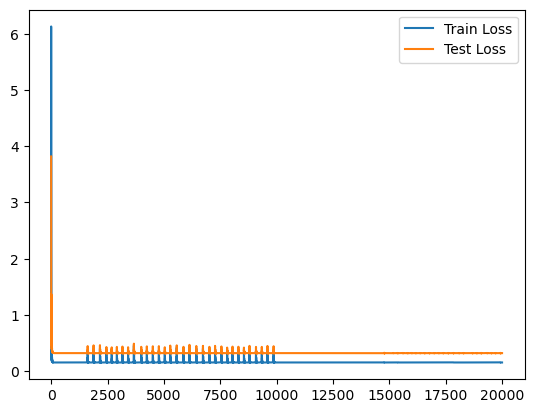

In [347]:
ax = plt.subplot()
ax.plot(train_loss, label='Train Loss')
ax.plot(test_loss, label='Test Loss')
ax.legend()

Single-step prediction

In [348]:
actual = pd.DataFrame(ss.inverse_transform(y_test.detach().numpy().reshape(-1,1))).rename({0:'actual'},axis=1)
pred = pd.DataFrame(ss.inverse_transform(model(X_test).detach().numpy())).rename({0:'single_pred'},axis=1)

<Axes: >

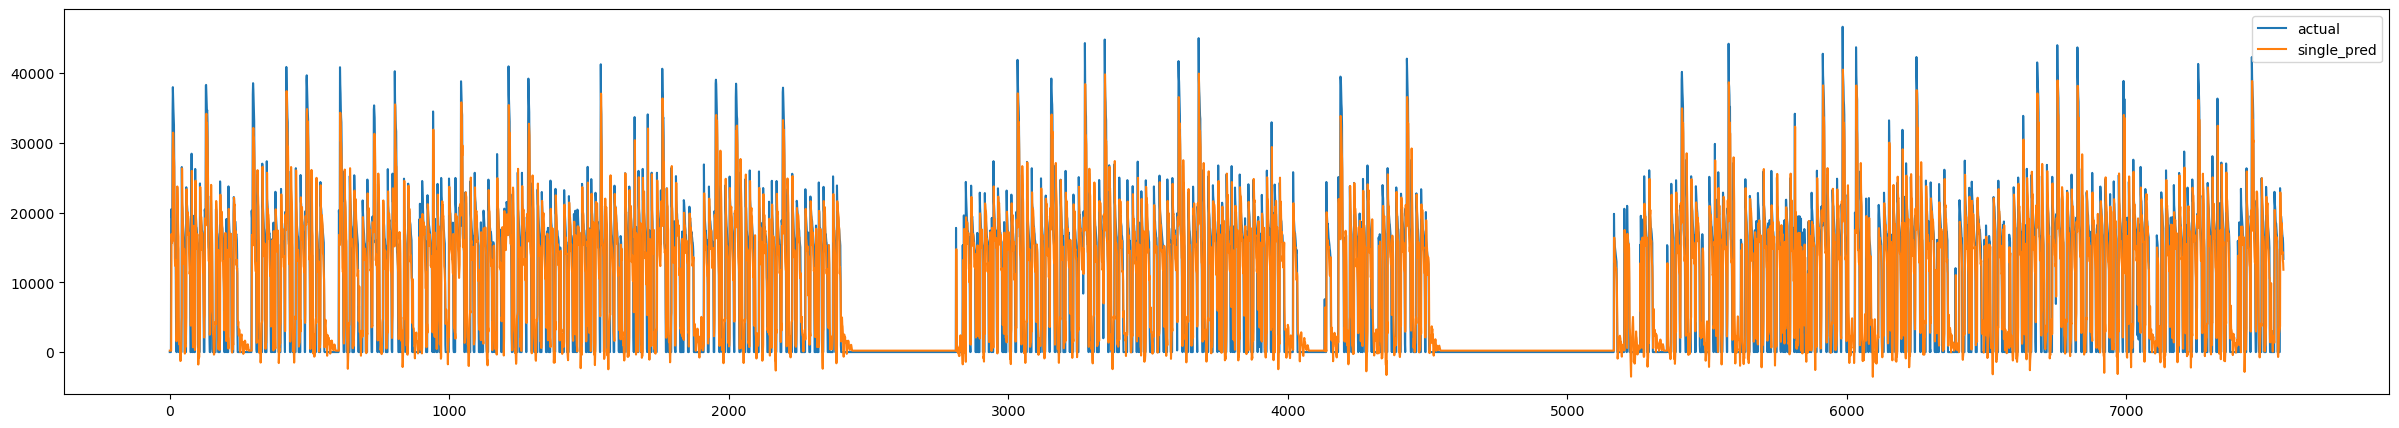

In [349]:
actual_pred = pd.concat([actual, pred], axis=1)
actual_pred.plot(figsize=(30,5))

In [350]:
rmse = float(np.sqrt(sum((actual.values - pred.values)**2)/len(actual)))
r2 = r2_score(actual, pred)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 5719.744140625
R2: 0.6896414168675769


Multi-step prediction

In [351]:
multi_pred = []
currX = X_test[0]

while len(multi_pred) != len(X_test):
    tensor_pred = model(currX)
    currX = torch.cat([currX, tensor_pred])
    currX = currX[-time_step:]
    pred = ss.inverse_transform(tensor_pred.detach().numpy().reshape(-1,1))
    multi_pred.append(float(pred))

In [352]:
pred_step = pd.DataFrame({"multi_pred":multi_pred})
pred_step.index = actual_pred.index

<Axes: >

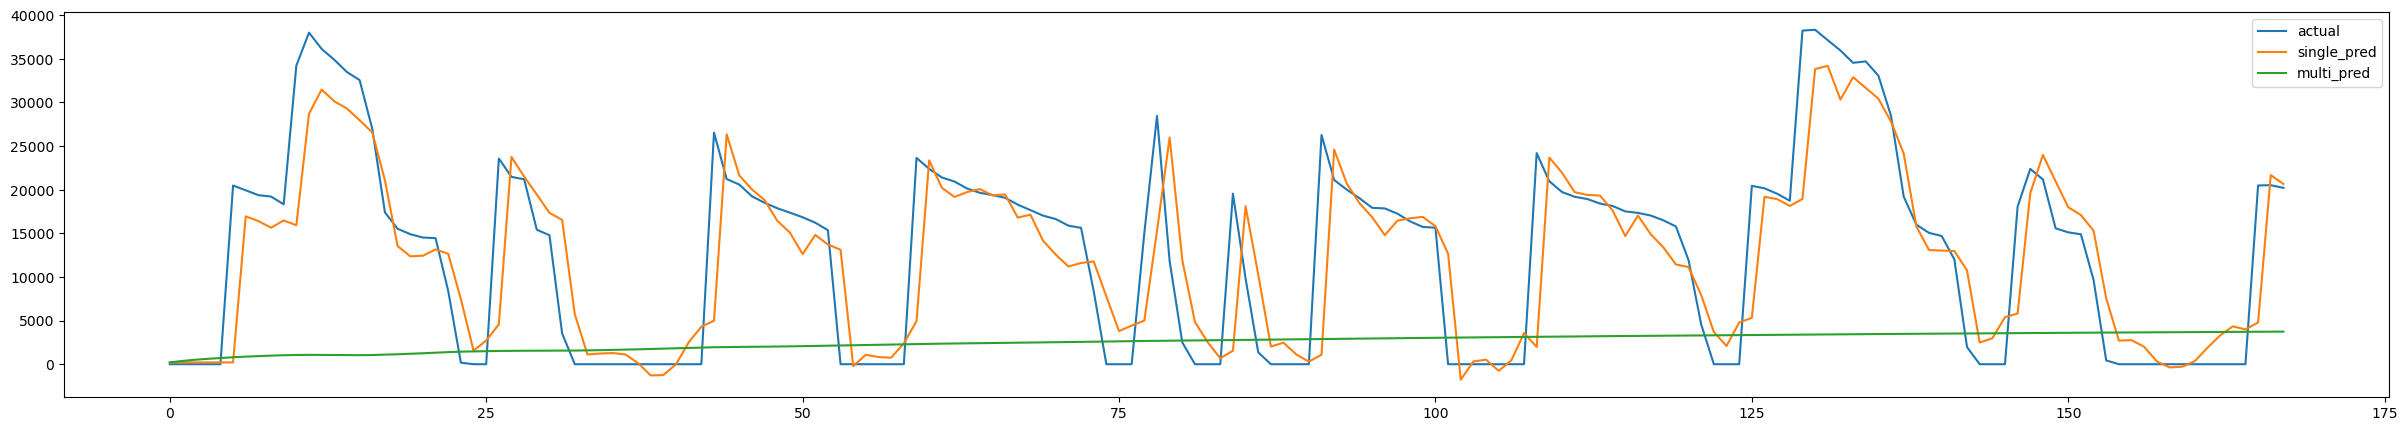

In [353]:
pd.concat([actual_pred, pred_step], axis=1)[:24*7].plot(figsize=(30,5))

In [354]:
pd.concat([actual_pred, pred_step], axis=1)[:24*7].sum().reset_index()

,index,0
0,actual,2.117035e+06
1,single_pred,2.014082e+06
2,multi_pred,4.304776e+05


For multiple step models

array([[12641.023]], dtype=float32)

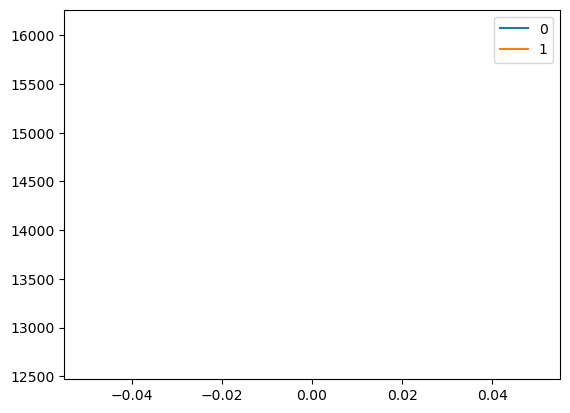

In [355]:
i = 550
actual = ss.inverse_transform(y_test[i].detach().numpy().reshape(-1,1))
pred = ss.inverse_transform(model(X_test[i]).detach().numpy().reshape(-1,1))
pd.DataFrame(np.concatenate([actual, pred], axis=1)).plot()
pred

# Sampler

In [78]:
class Single_step_PredSampler():
    def __init__(self, time_step, model, data):
        self.time_step = time_step
        self.model = model
        self.data = data
    def predict(self, numhours_to_predict, date_to_pred, plane_to_test, threshold_enable, threshold=5000):
        orig_date_to_pred = pd.to_datetime(date_to_pred)
        date_to_pred = pd.to_datetime(date_to_pred)
        input_start_date = date_to_pred - pd.Timedelta(hours=self.time_step)
        input_end_date = date_to_pred - pd.Timedelta(hours=1)
        input_df = self.data[plane_to_test][input_start_date:input_end_date]
        input_X = input_df.values.reshape(-1,1)
        ss = StandardScaler()
        s_input_X = ss.fit_transform(input_X)
        ts_input_X = torch.from_numpy(s_input_X.reshape(-1).astype(np.float32))
        mul_ts_input_X = ts_input_X
        pred_list = []
        
        for i in range(numhours_to_predict):
            ts_pred = self.model(ts_input_X)
            mul_ts_pred = self.model(mul_ts_input_X)
            actual = hist[plane_to_test][date_to_pred]
            single_pred = ss.inverse_transform(ts_pred.detach().numpy().reshape(-1,1))
            multi_pred = ss.inverse_transform(mul_ts_pred.detach().numpy().reshape(-1,1))
            if threshold_enable:
                if single_pred < threshold:
                    single_pred = [[0]]
                if multi_pred < threshold:
                    multi_pred = [[0]]
            date_to_pred += pd.Timedelta(hours=1)
            
            add_actual = torch.from_numpy(ss.transform(np.array(actual).reshape(-1,1)).reshape(-1).astype(np.float32))
            ts_input_X = torch.cat([ts_input_X, add_actual])[1:]
            mul_ts_input_X = torch.cat([mul_ts_input_X, mul_ts_pred])[1:]
            
            pred_list.append([actual, single_pred[0][0], multi_pred[0][0]])
            
        actual_data = hist[plane_to_test][orig_date_to_pred:orig_date_to_pred + pd.Timedelta(hours=numhours_to_predict-1)]
        pred_df = pd.DataFrame(np.array(pred_list))
        pred_df.columns = ['actual', 'single_pred', 'multi_pred']
        pred_df.index = actual_data.index
        return pred_df
    def full_predict(self, plane_to_test):
        data = self.data[[plane_to_test]]
        ss = StandardScaler()
        ss_data = ss.fit_transform(data)
        X = []
        for i in range(self.time_step, data.shape[0]):
            X.append(list(ss_data[i-self.time_step:i].reshape(-1)))
        X = torch.from_numpy(np.array(X).astype(np.float32))
        pred = self.model(X).detach().numpy()
        pred_df = pd.DataFrame(ss.inverse_transform(pred))
        return pred_df
    
class Multi_step_PredSampler():
    def __init__(self, time_step, model, data):
        self.time_step = time_step
        self.model = model
        self.data = data
    def predict(self, date_to_pred, plane_to_test):
        orig_date_to_pred = pd.to_datetime(date_to_pred)
        date_to_pred = pd.to_datetime(date_to_pred)
        input_start_date = date_to_pred - pd.Timedelta(hours=self.time_step)
        input_end_date = date_to_pred - pd.Timedelta(hours=1)
        input_df = self.data[plane_to_test][input_start_date:input_end_date]
        input_X = input_df.values.reshape(-1,1)
        ss = StandardScaler()
        s_input_X = ss.fit_transform(input_X)
        ts_input_X = torch.from_numpy(s_input_X.reshape(-1).astype(np.float32))
        pred = self.model(ts_input_X)
        pred_df = pd.DataFrame(ss.inverse_transform(pred.detach().numpy().reshape(-1,1)))
        actual_df = self.data[plane_to_test][orig_date_to_pred:orig_date_to_pred + pd.Timedelta(hours=self.model.out_features-1)]
        pred_df.index = actual_df.index
        actual_pred = pd.concat([actual_df, pred_df], axis=1)
        actual_pred.columns = ['actual', 'multi_pred']
        return actual_pred

In [79]:
pred_sampler = Single_step_PredSampler(model.in_features, model, hist)

,rp7772,rp7772_pred,rp7773,rp7773_pred,rp7774,rp7774_pred,rp7775,rp7775_pred,rp7776,rp7776_pred,rp7777,rp7777_pred,rp7778,rp7778_pred,rp7779,rp7779_pred,rp7782,rp7782_pred
index,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,14937.640000,NaN,0.0,NaN,0.0,NaN,0.0,NaN,13186.493333,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2022-01-01 01:00:00,7586.662222,NaN,0.0,NaN,0.0,NaN,0.0,NaN,9737.026667,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2022-01-01 02:00:00,61.453333,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1589.364444,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2022-01-01 03:00:00,17754.422222,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2022-01-01 04:00:00,15098.808889,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-24 18:00:00,16529.582222,14362.637695,0.0,6.807984,0.0,-14.575344,0.0,-5.753339,0.000000,-4.391776,0.0,2.854092,0.0,14.925796,0.0,13.089641,0.0,15.315453
2023-09-24 19:00:00,16379.431111,13237.653320,0.0,6.807984,0.0,-14.575344,0.0,-5.753339,0.000000,-4.391776,0.0,2.854092,0.0,14.925796,0.0,13.089641,0.0,15.315453
2023-09-24 20:00:00,15552.746667,12266.647461,0.0,6.807984,0.0,-14.575344,0.0,-5.753339,0.000000,-4.391776,0.0,2.854092,0.0,14.925796,0.0,13.089641,0.0,15.315453


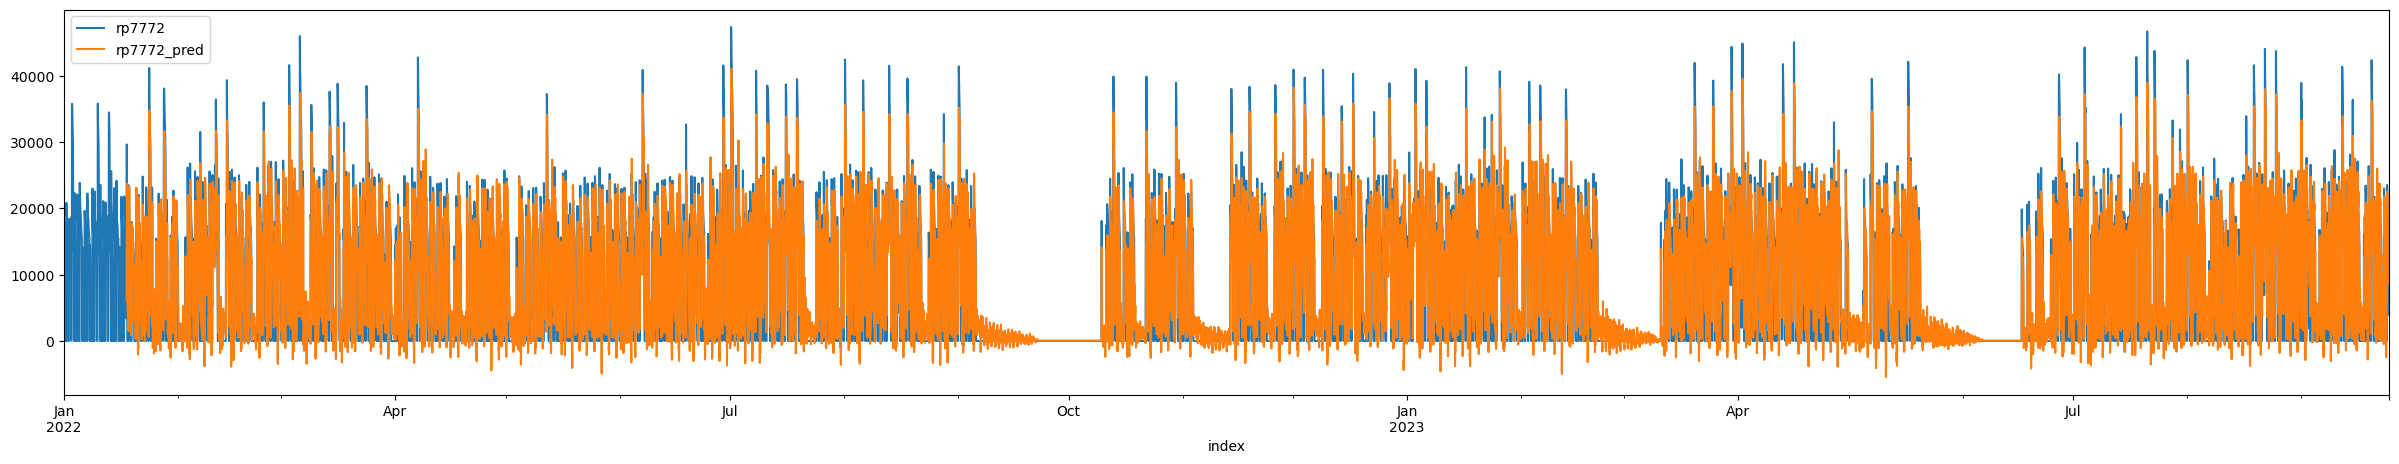

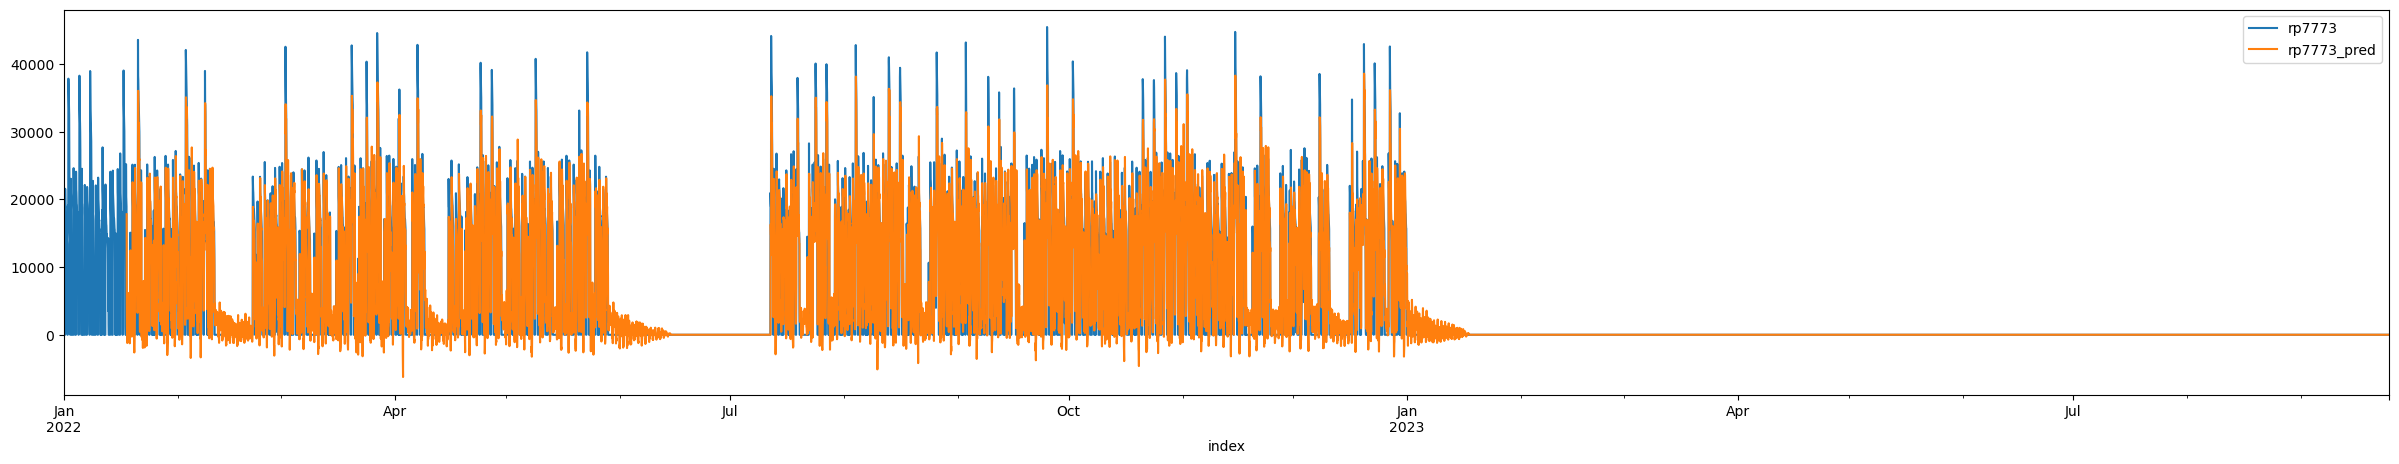

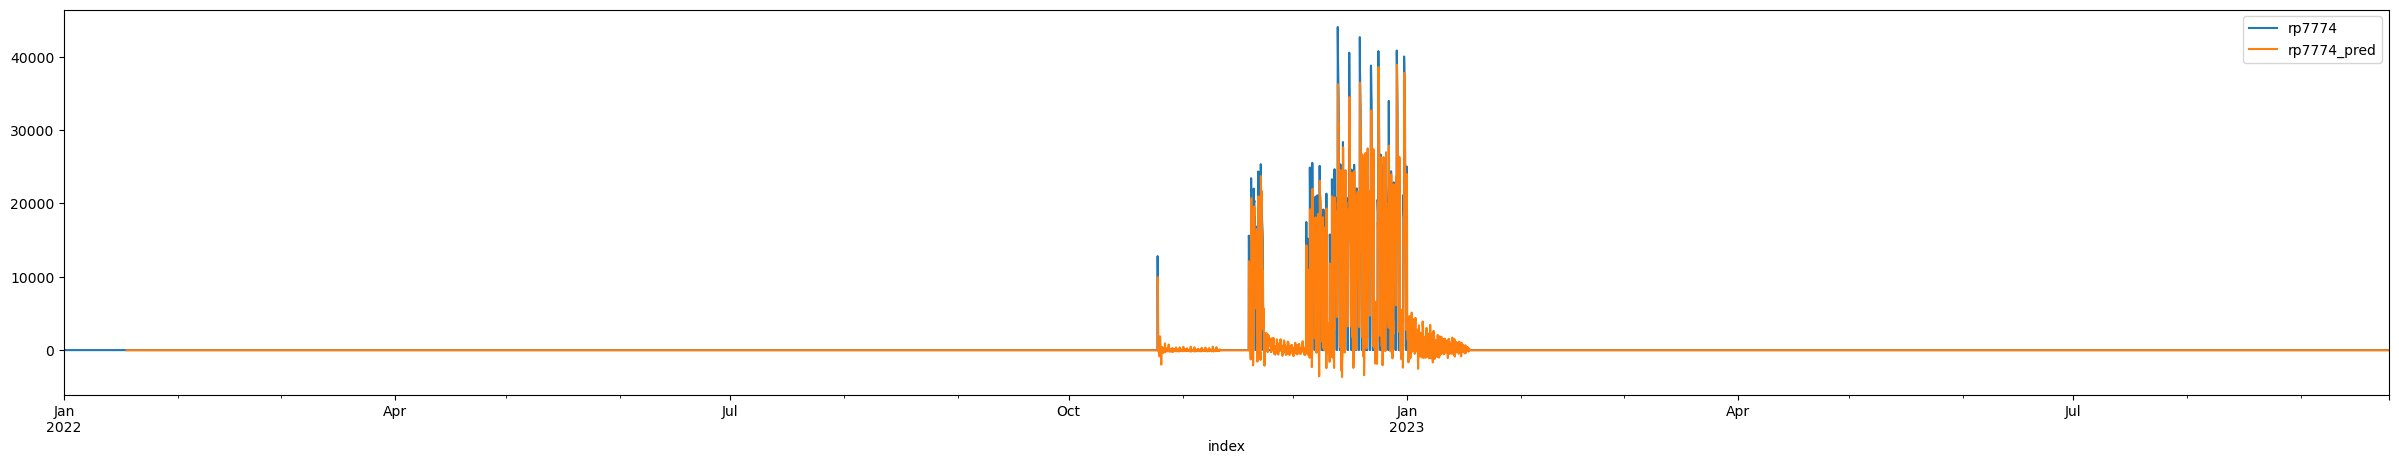

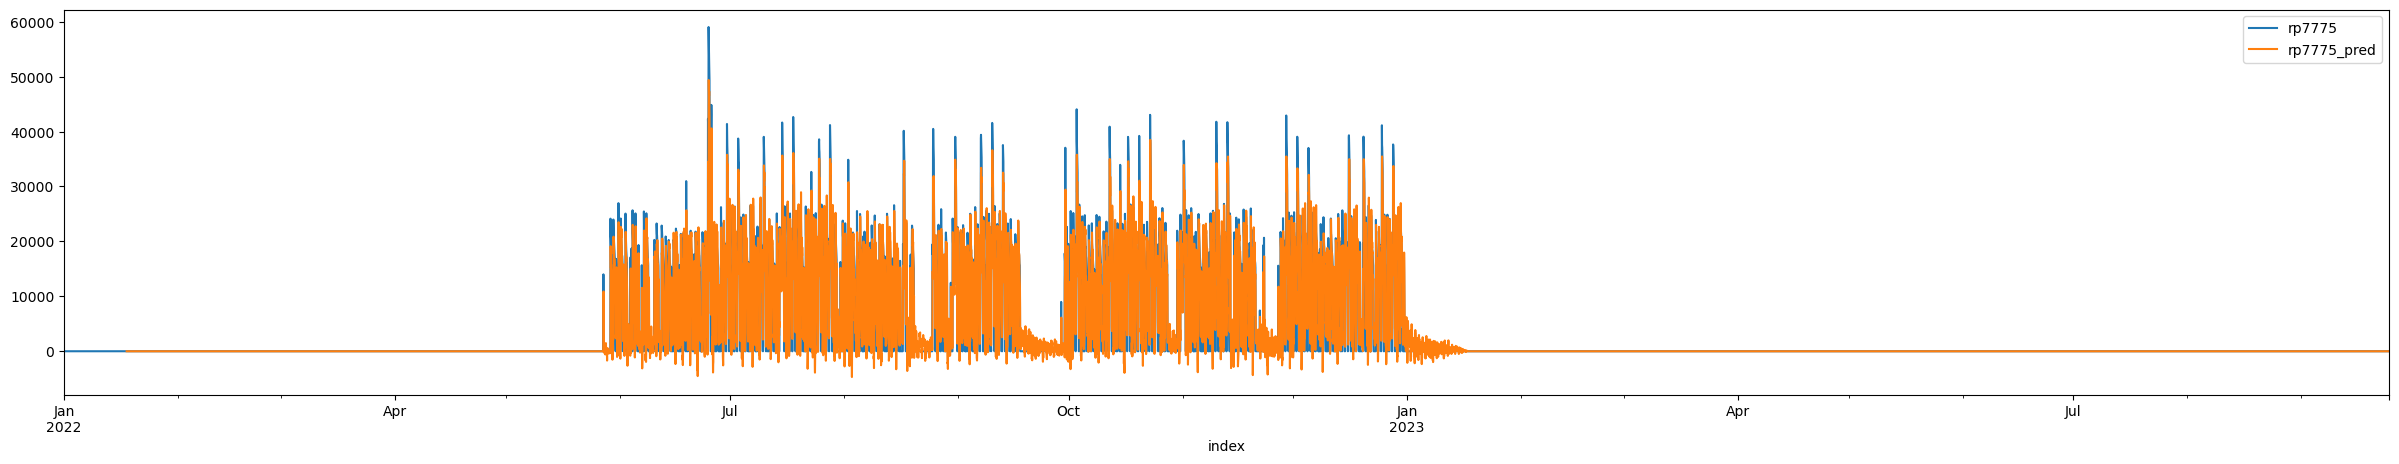

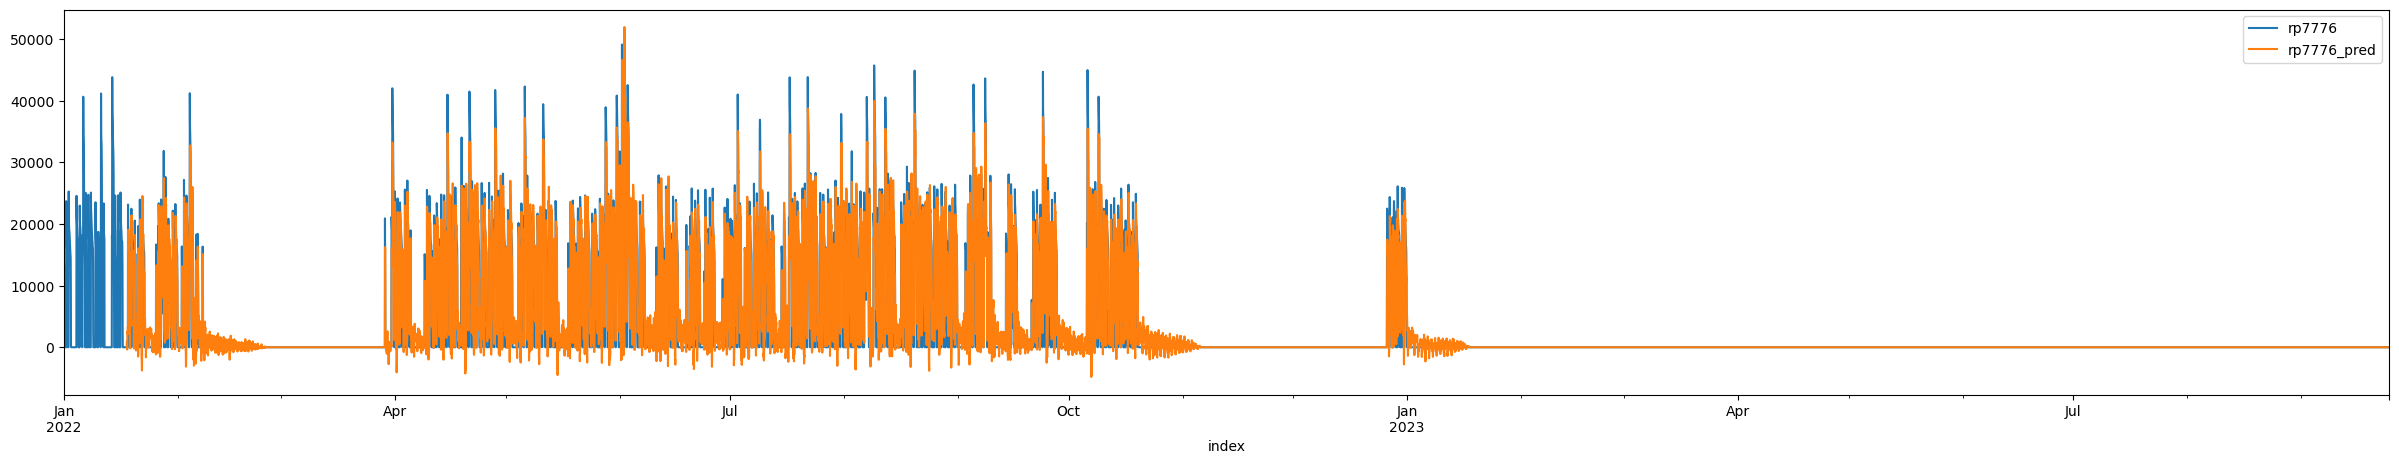

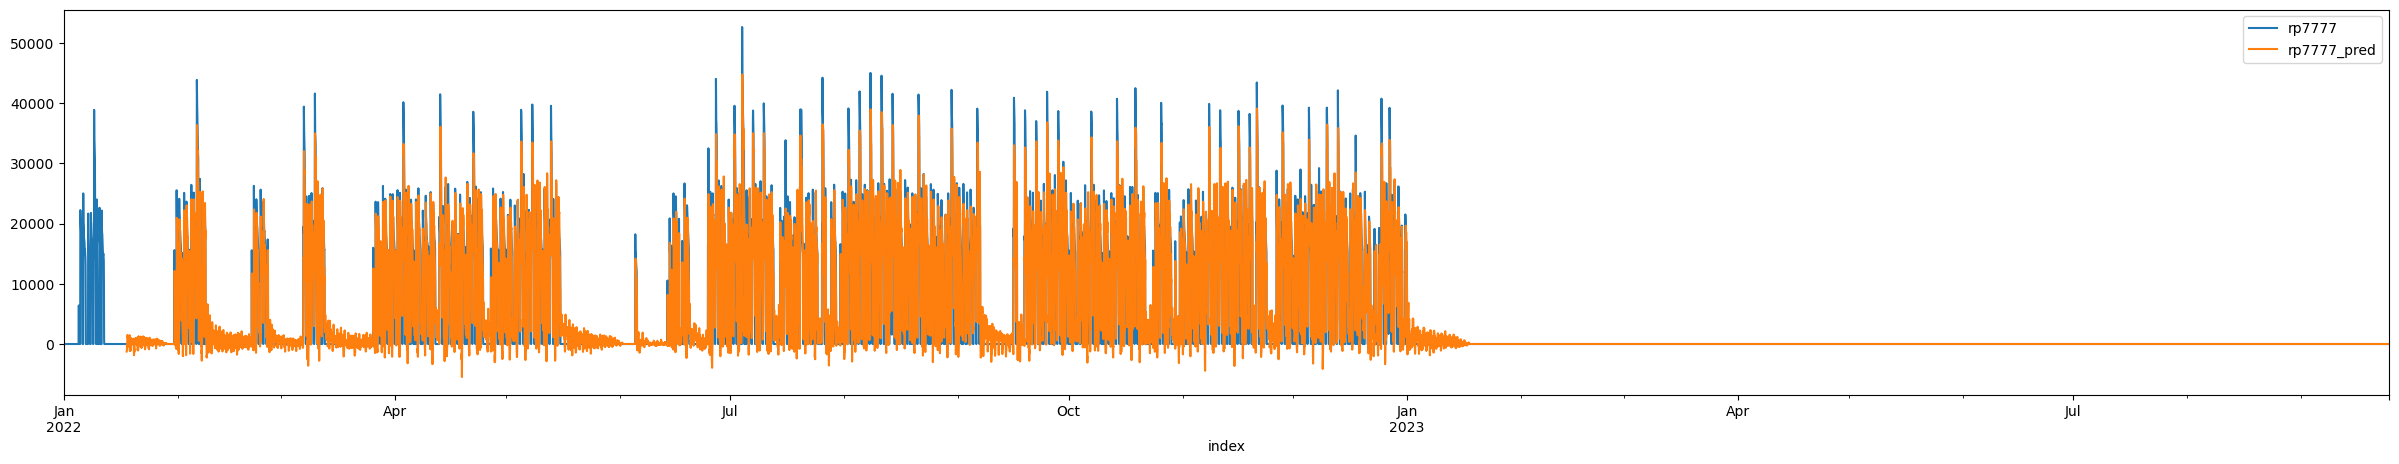

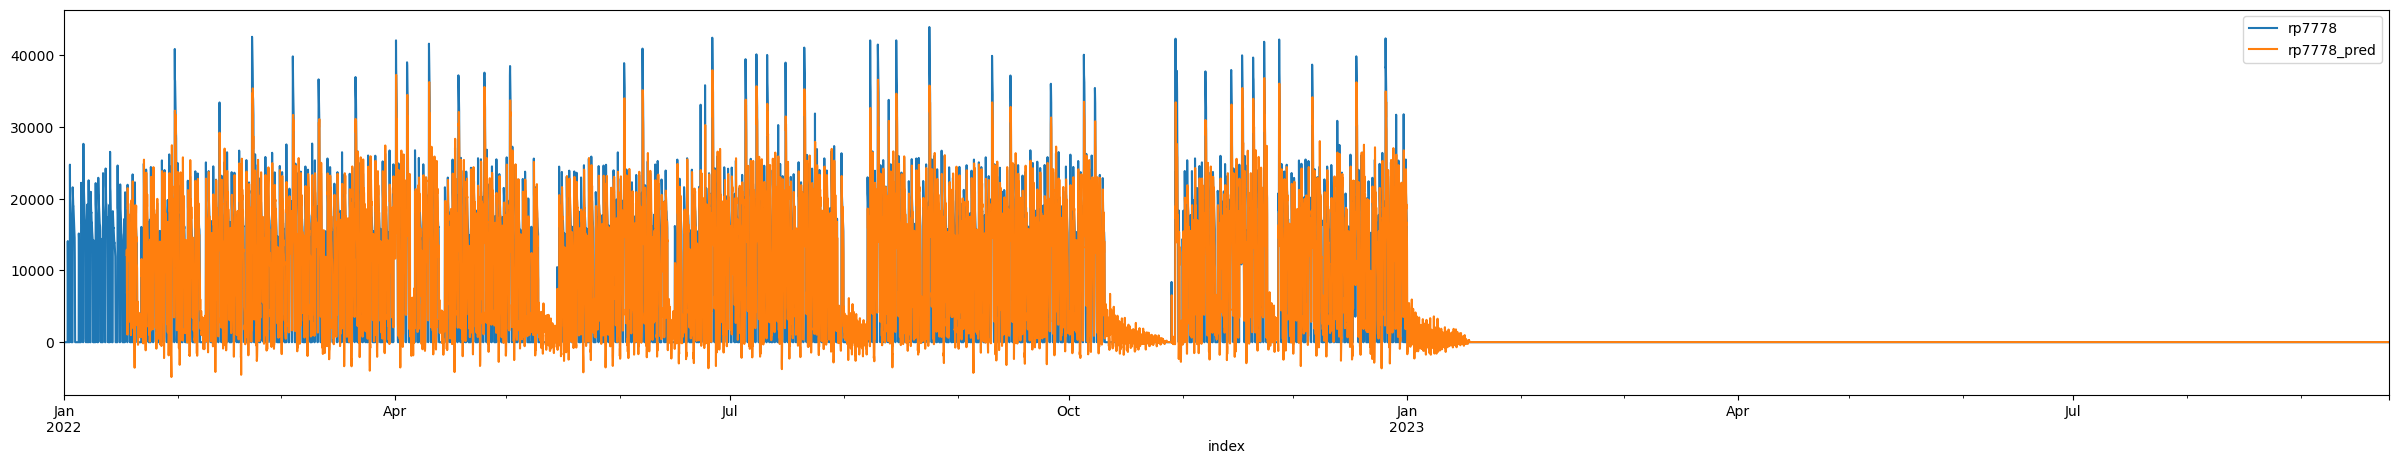

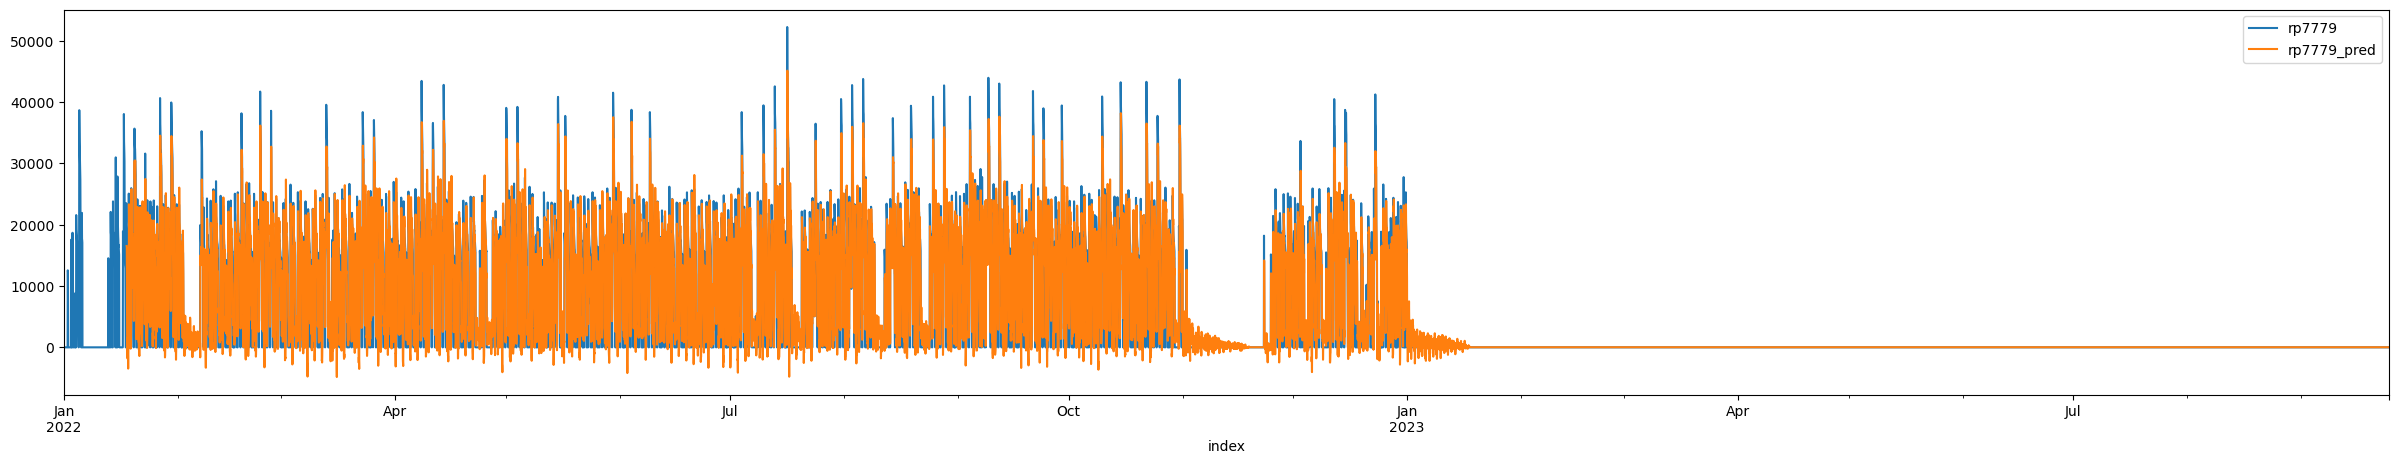

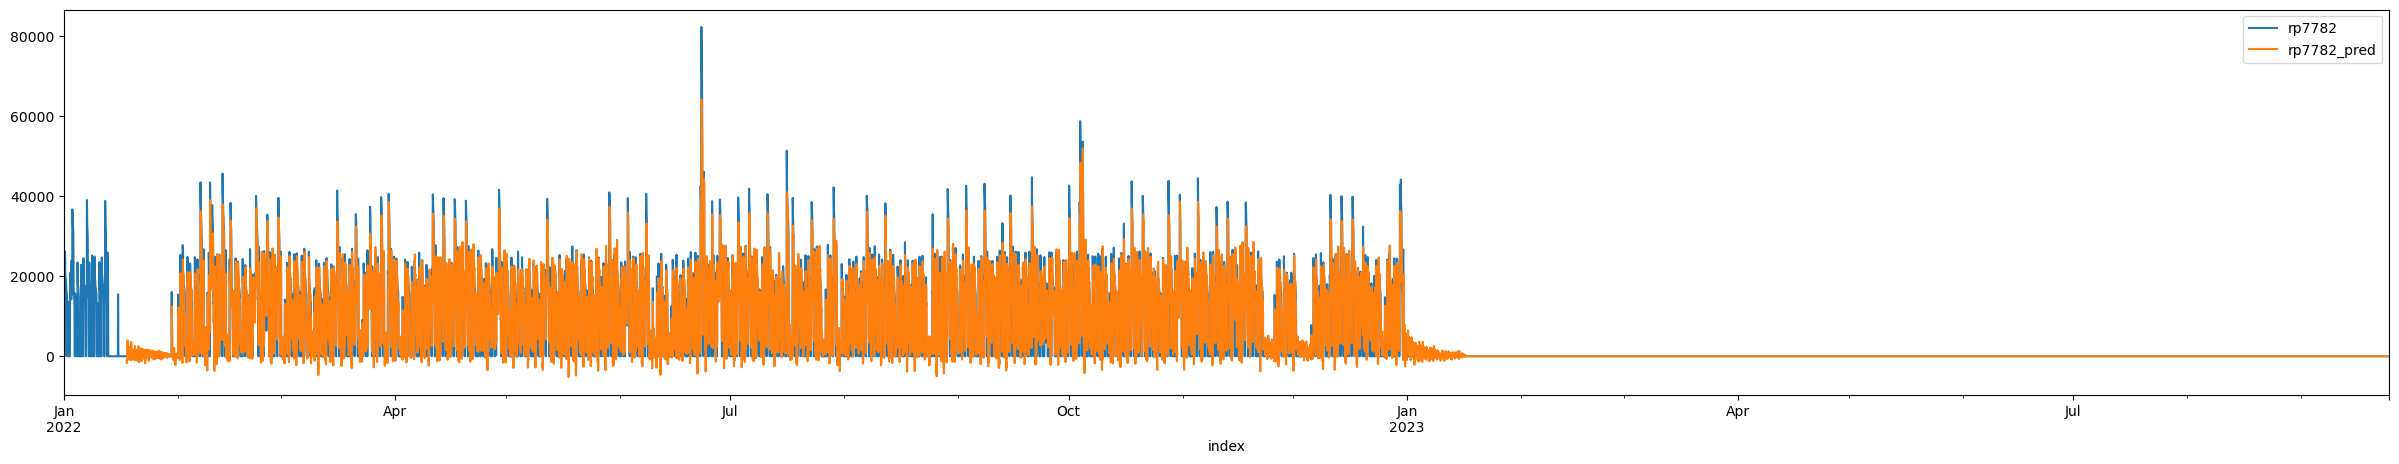

In [86]:
plane_df = pd.DataFrame()
planes = list(hist.columns)
for plane in planes:
    pred = pred_sampler.full_predict(plane)
    pred = pd.concat([pd.DataFrame([np.nan] * model.in_features), pred])
    pred = pred.rename({0:plane + '_pred'}, axis=1).reset_index().drop('index', axis=1)
    pred.index = hist.index
    actual_pred = pd.concat([hist[plane], pred], axis=1)
    actual_pred.plot(figsize=(30,5))
    plane_df = pd.concat([plane_df, actual_pred], axis=1)
plane_df

In [92]:
plane_df.to_csv('csv/planes_h.csv')
plane_df.resample('D').sum().to_csv('csv/planes_d.csv')
plane_df.resample('W-SAT').sum().to_csv('csv/planes_w.csv')
plane_df.resample('M').sum().to_csv('csv/planes_m.csv')

In [15]:
multi_agg = []
prediction_steps = 7*24
for each in hist.iloc[time_step:len(hist)-prediction_steps,0].index:
    result = pred_sampler.predict(prediction_steps, each, 'rp7772', True)
    multi_agg.append(list(result.sum().values))
    print(each)

NameError: name 'time_step' is not defined

In [20]:
multi_agg_df = pd.DataFrame(multi_agg)
multi_agg_df.index = hist.iloc[time_step:len(multi_agg_df) + time_step,0].index
multi_agg_df.columns = ['actual', 'single_pred', 'multi_pred']
multi_agg_df

,actual,single_pred,multi_pred
index,,,
2022-01-18 00:00:00,1.889698e+06,1.722845e+06,1.722516e+06
2022-01-18 01:00:00,1.874574e+06,1.732951e+06,1.829443e+06
2022-01-18 02:00:00,1.844965e+06,1.718968e+06,2.002541e+06
2022-01-18 03:00:00,1.819896e+06,1.700307e+06,2.002287e+06
2022-01-18 04:00:00,1.802588e+06,1.678301e+06,1.936103e+06
...,...,...,...
2023-09-17 18:00:00,1.947991e+06,1.783692e+06,1.267274e+06
2023-09-17 19:00:00,1.964521e+06,1.798021e+06,1.264452e+06
2023-09-17 20:00:00,1.980900e+06,1.811224e+06,1.249666e+06


In [43]:
print('r2:', r2_score(test['actual'], test['single_pred']))
print('rmse:', np.sqrt(sum((test['actual'] - test['single_pred'])**2)/len(test)))

r2: 0.9736132576150767
rmse: 119447.51335465255


In [705]:
def simulate_lag(lag, multi_agg_df):
    lag_df = multi_agg_df['multi_pred'][lag:].reset_index().drop('index', axis=1)
    lag_df = pd.concat([lag_df,pd.DataFrame({'multi_pred':[np.NaN] * lag})]).reset_index().drop('index', axis=1)
    lag_df = lag_df.rename({'multi_pred':'lag_pred'}, axis=1)
    lag_df.index = multi_agg_df.index
    return pd.concat([multi_agg_df, lag_df], axis=1)

lagr2: 0.6684558494154362
lagrmse: 5818.377504313707


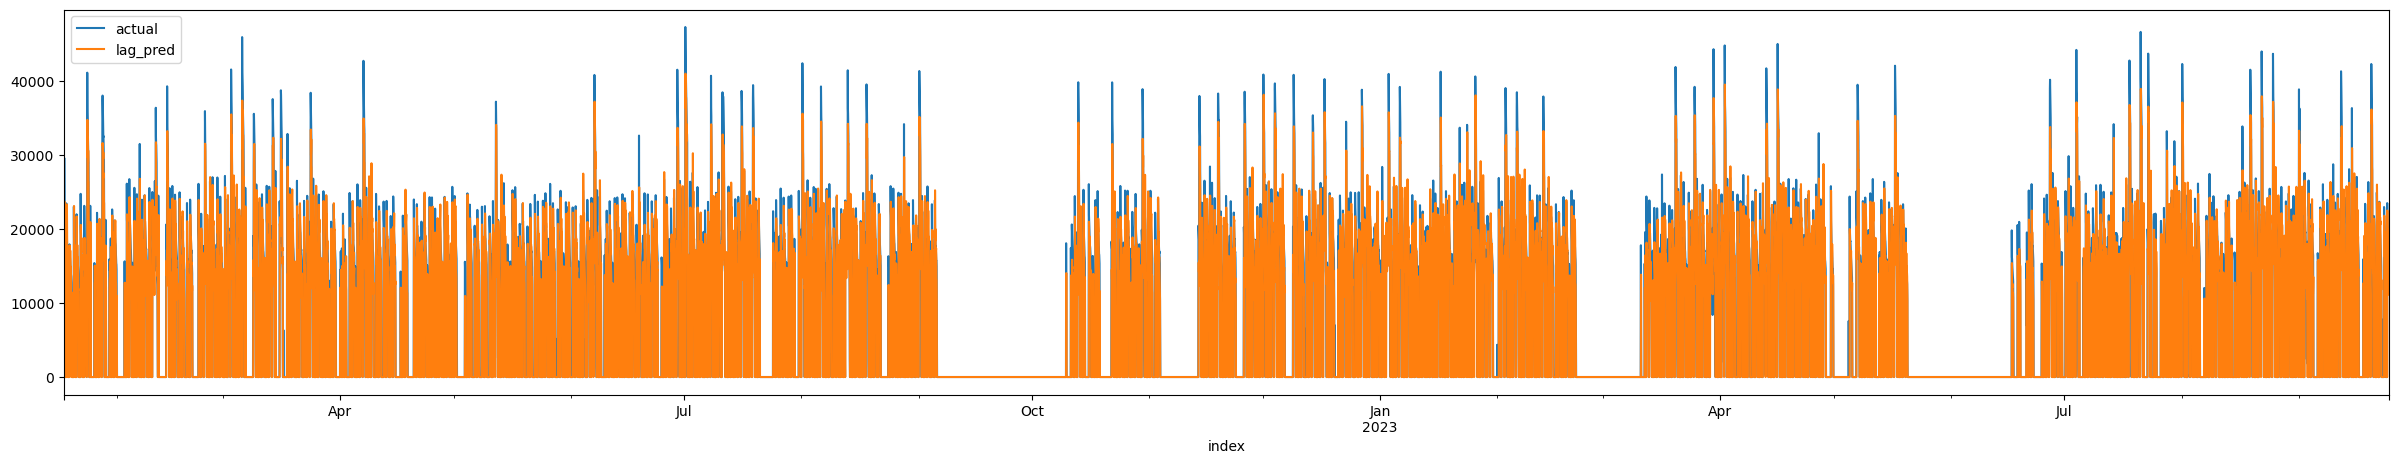

In [706]:
lag_version = simulate_lag(0, multi_agg_df)
lag_version[['actual', 'lag_pred']].plot(figsize=(30,5))
lag = lag_version.dropna()[['actual', 'lag_pred']]
print('lagr2:', r2_score(lag['actual'], lag['lag_pred']))
print('lagrmse:', np.sqrt(sum((lag['actual'] - lag['lag_pred'])**2)/len(lag)))

lagr2: 0.6684558494154362
lagrmse: 5818.377504313707


<Axes: xlabel='index'>

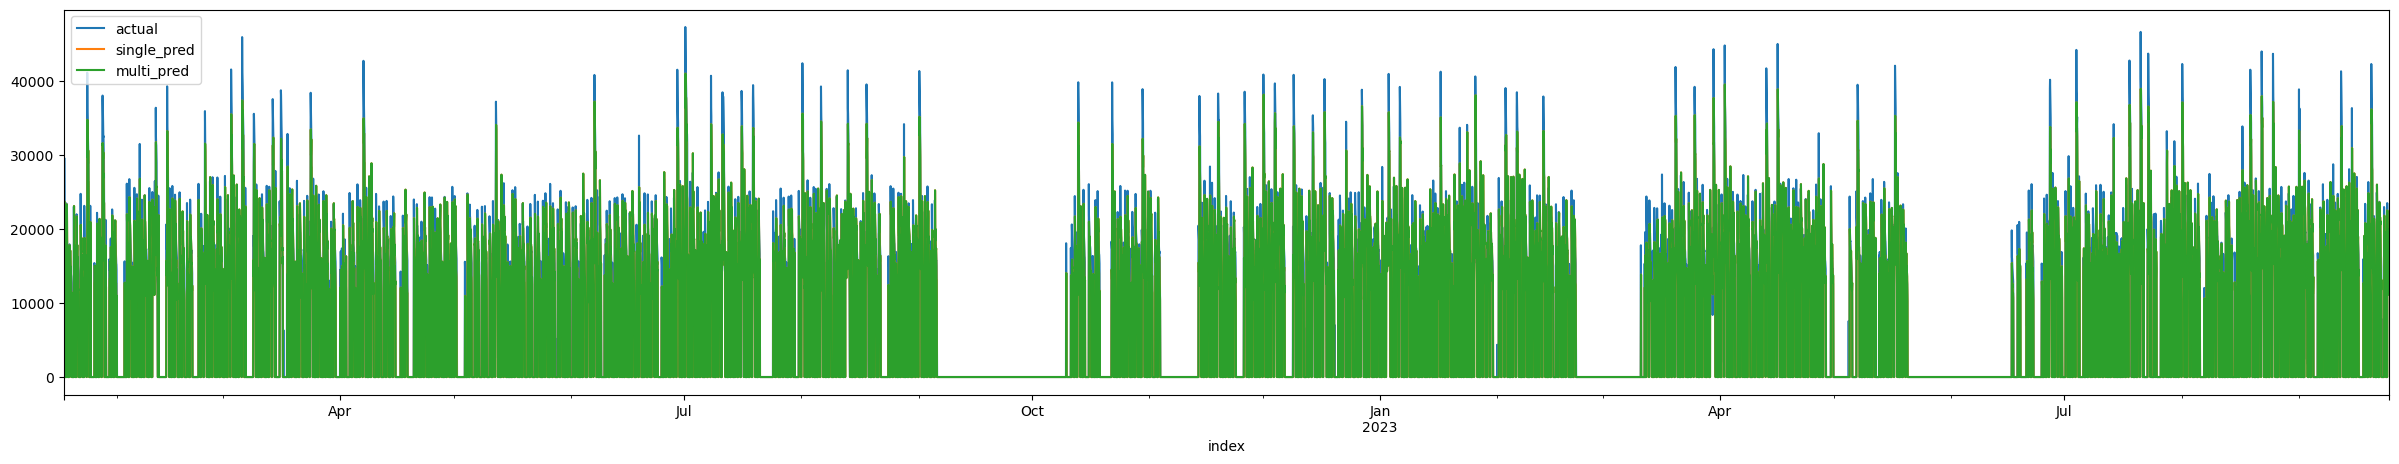

In [707]:
print('lagr2:', r2_score(lag['actual'], lag['lag_pred']))
print('lagrmse:', np.sqrt(sum((lag['actual'] - lag['lag_pred'])**2)/len(lag)))
multi_agg_df.plot(figsize=(30,5))

# Save/Load Model

In [11]:
directory = input('Directory to save the model: ')
filename = input('Model Name: ')
torch.save(auto_reg, directory + filename + '.pt')

Directory to save the model: C:\Users\Kyle Carlo C. Lasala\Desktop\PAL\repo\Predicting-Fuel-Consumption\
Model Name: AutoRegressive-h


NameError: name 'auto_reg' is not defined

In [3]:
directory = input('Directory to save the model: ')
filename = input('Model Name: ')
load_mod = torch.load(directory + filename + '.pt')
model = load_mod
model.eval()

Directory to save the model: C:\Users\Kyle Carlo C. Lasala\Desktop\PAL\repo\Predicting-Fuel-Consumption\
Model Name: AutoRegressive-h


Linear(in_features=408, out_features=1, bias=True)